In [1]:
# libraries
## system
from pathlib import Path
import os
## data manipulation
import pandas as pd
## analysis
import statsmodels.formula.api as smf
## plots
import seaborn as sns
import matplotlib.pyplot as plt

## local library
### load data
from sad2_final_project.analysis import loader_obsolete_data, experiment_data_loader, add_missing_metrics_from_experiment, analyze_datasets_from_index
### general plots
from sad2_final_project.analysis import plot_scatter, plot_scatter_subplots, plot_boxplot, plot_grouped_boxplots
### Statistical analysis and associated plots
from sad2_final_project.analysis import compute_spearman_table, plot_spearman_heatmap, compute_wilcoxon_table, plot_wilcoxon_heatmap
# Path management
## set cwdir to repository folder 
cwd=Path.cwd()
if cwd.name == "notebooks":
    os.chdir(cwd.parent)
print(os.getcwd())

## create paths
DATA_PATH = Path('data')
#DATASET_1_PATH = DATA_PATH / Path('experiment_12_merged')
DATASET_2_S_PATH = DATA_PATH / Path('experiment_34_synchronous_merged')
DATASET_2_A_PATH = DATA_PATH / Path('experiment_34_asynchronous_merged')

/home/asia/rok3/sad2/final_project/SAD2_final_project


In [2]:
# Data loading 
## Dataset 1 - experiments 1, 2
#df = experiment_data_loader(DATASET_1_PATH)
## Dataset 2 - experiments 3, 4
dfs = experiment_data_loader(DATASET_2_S_PATH).drop(columns=['part_x', 'part_y'])
dfa = experiment_data_loader(DATASET_2_A_PATH).drop(columns=['part_x', 'part_y'])

## Add all metrics
metrics_list=['TP', 'FP', 'FN', 'f1', 'accuracy', 'precision', 'recall', 'sensitivity', 'AHD', 'SHD', 'EHD', 'SID']
#df = add_missing_metrics_from_experiment(df, DATASET_1_PATH, metrics_list, after_column='attractor_ratio')
dfs = add_missing_metrics_from_experiment(dfs, DATASET_2_S_PATH, metrics_list, after_column='attractor_ratio')
dfa = add_missing_metrics_from_experiment(dfa, DATASET_2_A_PATH, metrics_list, after_column='attractor_ratio')
#df1 = df[df["trajectory_length"]>=10] # dataset1


[Progress] 1000/2100 conditions completed (47.6%)
[Progress] 2000/2100 conditions completed (95.2%)
[Progress] 1000/2100 conditions completed (47.6%)
[Progress] 2000/2100 conditions completed (95.2%)


# Introduction 
## Goal
The goal of this study is to investigate the relation between **sampling strategy** and **model selection metrics** in *boolean Bayesian networks (BDNs)* using `BNFinder2`. 

In particular, we analyze how characteristics of time-series data generated from Boolean networks influence the accuracy of reconstructing the underlying network structure using Bayesian methods. The experimental factors under investigation include:
- the **trajectory length**,
- the **sampling frequency**, defined as selecting every $n$-th state along a trajectory,
- the ratio between the **number of nodes** and the **trajectory length**, introduced as a normalization parameter $k$.

The generated datasets are grouped into classes determined by:
- the **update mode** (synchronous vs asynchronous),
- the **scoring function** used during inference (MDL and BDe).

In addition, we study **scaling relations with respect to the number of nodes**, aiming to characterize how data requirements and reconstruction accuracy change as network size increases.

# Part 1

## Methodology
### General reasoning 
The primary objective of the experimental design is to isolate how properties of sampled time-series data affect the accuracy of Boolean network reconstruction using `BNFinder2`. 
***
#### Update Mode
We distinguish between two fundamentally different update mechanisms:
- **Synchronous update**, which defines a deterministic dynamical system: from any given state, the successor state is uniquely determined.
- **Asynchronous update**, which induces a stochastic process: at each time step, a randomly selected node is updated, leading to multiple possible successor states.

This distinction is critical, as asynchronous dynamics introduce temporal dependence and potential autocorrelation in trajectories. In particular, long residence times in attractors or local cycles may reduce the effective information content of sampled data. Consequently, naive dense sampling may lead to strongly correlated observations, while aggressive subsampling may destroy causal ordering information.
***
#### Scoring Functions
We employ two scoring functions implemented in BNFinder2, which differ in how they trade off data fit against model complexity.
Let $G$ denote a candidate network structure and $D$ the observed dataset.

**Minimal Description Length (MDL)**

The MDL score is defined as
$$
\mathrm{MDL}(G \mid D)
= - \log P(D \mid G, \hat{\theta})
\times \frac{1}{2} , |\theta_G| , \log |D|,
$$


where $\hat{\theta}$ are maximum-likelihood parameters and $|\theta_G|$ denotes the number of free parameters implied by the graph structure $G$.

The first term rewards goodness of fit, while the second term penalizes model complexity. As a consequence, MDL favors simpler graphs when data are scarce and becomes less restrictive as sample size increases. This makes MDL particularly sensitive to undersampling and normalization effects.

**Bayesian–Dirichlet equivalence (BDe)**

The BDe score evaluates the marginal likelihood

$$
\mathrm{BDe}(G \mid D)
= - \log \int P(D \mid G, \theta), P(\theta \mid G), d\theta,
$$

assuming a Dirichlet prior over conditional probability tables. Under standard assumptions, this integral has a closed-form.

Unlike MDL, BDe incorporates prior beliefs and smooths parameter estimates, which can stabilize inference in low-data regimes but may also reduce sensitivity to subtle structural differences.

By comparing MDL and BDe, we assess whether observed reconstruction effects are driven primarily by data properties or by the inductive bias of the scoring function.

One caveat is that our implementation of those functions is simplified compared to implemented in BNfinder, value obtained is different but monotonicity is preserved and therefore do not affect the validity of our conclusions.

---

#### Evaluation Metrics
Reconstruction quality is evaluated using structure-based graph distance measures. Each metric captures a distinct notion of discrepancy between the true network $G^\ast$ and the inferred network $\hat{G}$. 

**Adjusted Hamming Distance (AHD)**

Let $A^\ast$ and $\hat{A}$ denote the adjacency matrices of $G^\ast$ and $\hat{G}$. The adjusted Hamming distance is defined as

$$
\mathrm{AHD}(G^\ast, \hat{G})
= \frac{1}{|E^\ast| + |\hat{E}|}
\sum_{i,j} \mathbf{1}_{{A^\ast_{ij} \neq \hat{A}_{ij}}}.
$$
AHD measures the proportion of mismatched edges, normalized by graph size and allows comparisons across networks of different sizes. This metric serves as the primary measure of structural accuracy.

**Structural Hamming Distance (SHD)**

SHD counts the minimum number of edge insertions, deletions, or reversals required to transform $\hat{G}$ into $G^\ast$.
$
\mathrm{SHD}(G^\ast, \hat{G}) \in \mathbb{N}.
$
While widely used, SHD aggregates heterogeneous error types and does not distinguish between missing, extra, or misoriented edges, limiting its interpretability.

**Structural Intervention Distance (SID)**

SID measures the number of node pairs $(i,j)$ for which the causal effect of intervening on $i$ differs between $G^\ast$ and $\hat{G}$.

$$
\mathrm{SID}(G^\ast, \hat{G})
= \left| {(i,j) : P(j \mid \mathrm{do}(i))*{G^\ast}
\neq P(j \mid \mathrm{do}(i))*{\hat{G}} } \right|.
$$
Where $\mathrm{do}(i=n)$ set node $i$ to have value $n$ at time step, regardles of Boolean update rule.

SID is sensitive to edge orientation and captures errors that affect causal interpretability, even when the undirected structure is largely correct.

Using these metrics jointly allows us to separate purely topological accuracy (AHD, SHD) from correctness of implied causal relationships (SID) and to identify metric-specific effects of sampling and model selection.

---
### Independence
To avoid introducing structural bias, Boolean networks are generated randomly for each condition:
- each node is assigned a random number of parents (uniformly chosen from $\{ 1 ,2 ,3 \}$),
- Boolean update functions are sampled randomly.
All generated networks are accepted without filtering. Repetitions under identical conditions are treated as independent realizations.
### Sample Size Normalization
To ensure comparability across networks of different sizes, we introduce **sample-size normalization**.
Let:
- $n_{\text{nodes}}$​ denote the number of nodes,
- $T_{\text{length}}$​ the trajectory length,
- $k$ a normalization constant.
The total number of sampled time points is defined as:
$$
\begin{align}
T_{\text{amount}} & = \frac{{n_{\text{nodes}} \cdot k}}{T_{\text{length}}} 
\end{align}
$$

We fix $k=100$. This choice is motivated by the fact that each node with at most three parents has up to $2^3 = 8$ possible parent-state configurations. Setting $k=100$ corresponds to approximately 10 observations per configuration per node, providing a conservative buffer against stochastic effects and subsampling losses.

### Dataset Construction
#### General Settings
Across all experiments, we vary the following parameters:
* number of nodes (`num_nodes`): ([5, 7, 11, 13, 15]),
* scoring function (`score_function`): MDL, BDe,
* update mode (`update_mode`): synchronous, asynchronous,
* parent count per node: randomly chosen from ({1,2,3}),
* number of repetitions per condition: 30.
---
#### Dataset 1 (Baseline Dataset)
This dataset is used in Experiments 1 and 2.
* trajectory length (`trajectory_length`): ([10, 15, 20, 30, 40, 50]),
* sampling frequency (`sampling_frequency`): ([1, 2, 3, 4, 5]),
* number of trajectories: determined via sample-size normalization.
---
#### Dataset 1.1 (Low-Data Regime)
To probe behavior in extreme data-scarce settings, an auxiliary dataset is constructed with:
* trajectory length: ([5, 7, 9]),
* number of nodes: ([5, 7, 9]),
* sampling frequency: ([1, 2, 3, 4, 5]).
This dataset is included to assess scaling behavior when normalization constraints are tight.
---
#### Dataset 2 (Normalization Study)
Using optimal parameters identified in Experiments 1 and 2, we fix:

$$\begin{align*} \text{sampling frequency} & =\begin{cases}1  & \text{synchronous} \\ 4 & \text{asynchronous}\end{cases} & \mathrm{trajectory\ length}=[0.8 \cdot x]_{\mathrm{round}}\end{align*}$$

We then vary the normalization constant:
$$k \in \{20, 40, 60, 80, 100, 120, 140\}$$

---
### Experiments
#### Experiment 1: Attractor Prevalence and Trajectory Length
Motivated by prior observations that attractor-heavy datasets degrade reconstruction quality, we investigate:
1. the correlation between attractor fraction and reconstruction metrics,
2. how attractor prevalence depends on trajectory length,
3. how these effects scale with network size.
We introduce the **scale ratio**
$$\text{scale ratio} = \frac{T_{\text{length}}}{n_{\text{nodes}}}$$
and analyze its relationship with attractor fraction to identify regimes that balance coverage of transient dynamics and attractor exploration.

---
#### Experiment 2: Subsampling and Temporal Dependence
The goal of this experiment is to identify an appropriate subsampling parameter by:

0. Reducing the effective amount of data via subsampling.
1. Examining whether there exists a relationship between *data characteristics*, quantified using **lag-1 autocorrelation (ACF)** and **effective sample size (ESS)**.
2. Examining whether there exists a relationship between data characteristics and reconstruction quality.
3. Assessing whether the relationship between data characteristics and reconstruction quality is statistically significant by evaluating **Spearman correlation tests** between ESS / ACF and reconstruction metrics, within groups defined by  
   (`num_nodes`, `update_mode`, `score_function`, `sampling_frequency`).
4. Assessing whether the relationship between **sampling frequency** and **reconstruction quality** is statistically significant by evaluating **Wilcoxon tests** on **AHD** and **SID** metrics for consecutive subsampling levels $(i \rightarrow i+1)$, within groups defined by   
   (`num_nodes`, `update_mode`, `score_function`).

This experiment concludes with the identification of optimal subsampling parameters as a function of `update_mode` and `score_function`.

---
#### Experiment 3: Normalization and Information Saturation

TODO - tutaj trzeba  poprawić po zrobieniu

Fixing sampling parameters based on earlier results, we analyze how reconstruction metrics evolve as a function of the normalization constant ($k$). This allows us to identify saturation regimes in which increasing sample size yields diminishing returns.

---
#### Experiment 4: Score Function Sensitivity
TODO - tutaj trzeba zmienić po zrobieniu
Finally, using a subset of Experiment 3 with fixed normalization, we investigate how reconstruction metrics depend on the choice of scoring function. The goal is to understand whether differences in reconstruction quality arise from data properties or from intrinsic characteristics of the scoring criteria.

## Analysis

### Experiment 1 

#### Determinants of Reconstruction Accuracy

The primary objective of this analysis was to identify the key factors influencing the accuracy of Boolean network reconstruction using dynamic Bayesian networks (DBNs). Specifically, we investigated how properties of the generated data (attractor ratio, trajectory length), network characteristics (number of nodes), and inference configuration (update mode and scoring function) affect reconstruction quality as measured by standard performance metrics.

##### Exploratory Correlation Analysis

We first conducted a pairwise correlation analysis between data characteristics and reconstruction metrics (precision, recall, SHD, and AHD). 

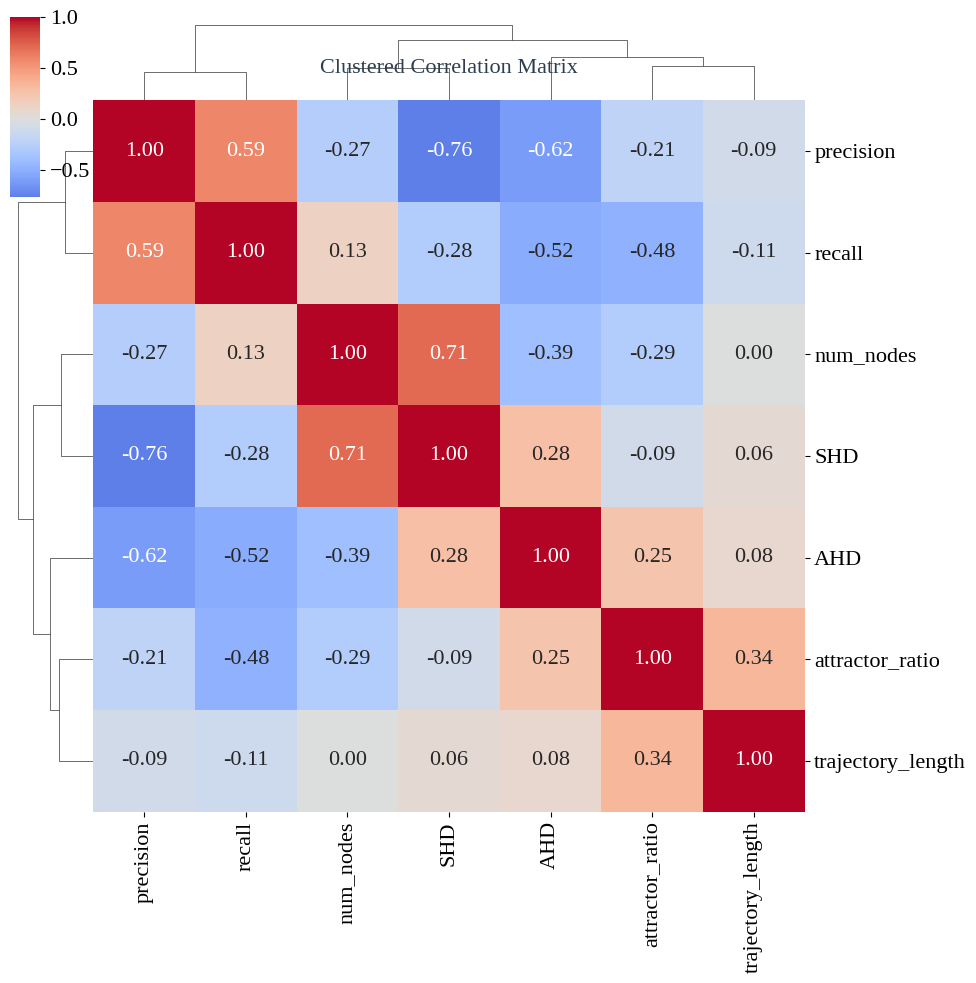

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df1[['attractor_ratio', 'num_nodes', 'trajectory_length', 'precision', 'recall', 'SHD', 'AHD']].corr(method='spearman')
g = sns.clustermap(corr_matrix, 
                   annot=True, 
                   cmap="coolwarm",
                   fmt=".2f",
                   figsize=(10, 10),
                   row_cluster=True,
                   col_cluster=True,
                   center=0,
                   dendrogram_ratio=0.1,
                   cbar_pos=(0.02, 0.8, 0.03, 0.18))
g.ax_heatmap.set_title("Clustered Correlation Matrix", fontsize=16, pad=20)
plt.show()

This exploratory step revealed several notable relationships:

- **Attractor ratio** exhibited a strong negative correlation with recall (r = –0.48), indicating that datasets dominated by attractor states substantially impair the recovery of true regulatory interactions.
- **Network size (number of nodes)** showed a strong positive correlation with SHD (r = 0.71), confirming that reconstruction error increases with network complexity.
- **Trajectory length** displayed near-zero correlations with all performance metrics, suggesting that its effect is not uniform and likely depends on interactions with other factors.

---

### Multivariate Regression Analysis

To quantify the independent contribution of each factor while controlling for others, we fitted ordinary least squares (OLS) regression models for structural error (SHD) and adjacency error (AHD). The primary model for SHD included attractor ratio, trajectory length, number of nodes, update mode, scoring function, and an interaction between attractor ratio and trajectory length:

```
SHD ~ attractor_ratio × trajectory_length + num_nodes + update_mode + score_function
```


In [4]:
model = smf.ols(
    "SHD ~ attractor_ratio * trajectory_length + num_nodes + update_mode + score_function",
    data=df1
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SHD   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     2332.
Date:                Sun, 25 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:44:20   Log-Likelihood:                -71233.
No. Observations:               18000   AIC:                         1.425e+05
Df Residuals:                   17993   BIC:                         1.425e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

The model explained approximately 44% of the variance in SHD (R² ≈ 0.44), indicating substantial explanatory power. The following effects were statistically significant:

- **Attractor ratio** had a strong positive effect on SHD, demonstrating that a higher proportion of attractor states in the data leads to increased structural reconstruction error.
- **Update mode** (synchronous vs. asynchronous) exerted a large effect, with synchronous updates yielding significantly higher error. This result was expected, as synchronous dynamics reduce the diversity of observable transitions, effectively decreasing the informational content of the data.
- **Scoring function** had a strong effect, with MDL outperforming BDe in terms of lower structural error.
- **Trajectory length** had a smaller but statistically significant effect on SHD, indicating that longer trajectories do not necessarily improve reconstruction accuracy under fixed sample size conditions.

---

### Interaction Effects and Mechanistic Insight

To further investigate how data characteristics interact, we fitted a second regression model for adjacency error (AHD) including the interaction term:

```
AHD ~ attractor_ratio × trajectory_length + num_nodes + update_mode + score_function
```

In [5]:
model2 = smf.ols(
    "AHD ~ attractor_ratio * trajectory_length + num_nodes + update_mode + score_function",
    data=df1
).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    AHD   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     832.7
Date:                Sun, 25 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:44:20   Log-Likelihood:                 10722.
No. Observations:               18000   AIC:                        -2.143e+04
Df Residuals:                   17993   BIC:                        -2.138e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

This model revealed a significant negative interaction between attractor ratio and trajectory length, indicating that longer trajectories partially mitigate the detrimental effect of high attractor dominance. In other words, while attractor-heavy datasets are generally less informative, increasing trajectory length can partially compensate by providing more opportunities to observe transient dynamics.

---

### Summary of Determinants

Overall, reconstruction accuracy was primarily influenced by:

1. **Update mode**, which strongly affected performance due to differences in the stochasticity and informational richness of the generated trajectories. This effect is intuitive, as reduced dynamical variability limits the ability to infer causal relationships.
2. **Scoring function**, with MDL consistently outperforming BDe under the studied conditions.
3. **Attractor ratio**, which emerged as the most influential data-related factor, particularly impairing recall and increasing structural error.
4. **Network size**, which substantially increased structural error due to scaling complexity.
5. **Trajectory length**, which had a secondary, interaction-dependent effect rather than a uniform influence.

These findings demonstrate that reconstruction accuracy is jointly determined by data composition, network complexity, and inference configuration, with attractor dominance playing a central role in limiting the informativeness of time-series data.

### Visualizing the Impact of Attractor Ratio on Reconstruction Error

To complement our regression analysis and gain an intuitive understanding of how **attractor dominance interacts with scoring function and update mode**, we generated scatter plots of **SHD, AHD, BDe and MDL versus attractor ratio**, stratified by **synchronous and asynchronous updates**.

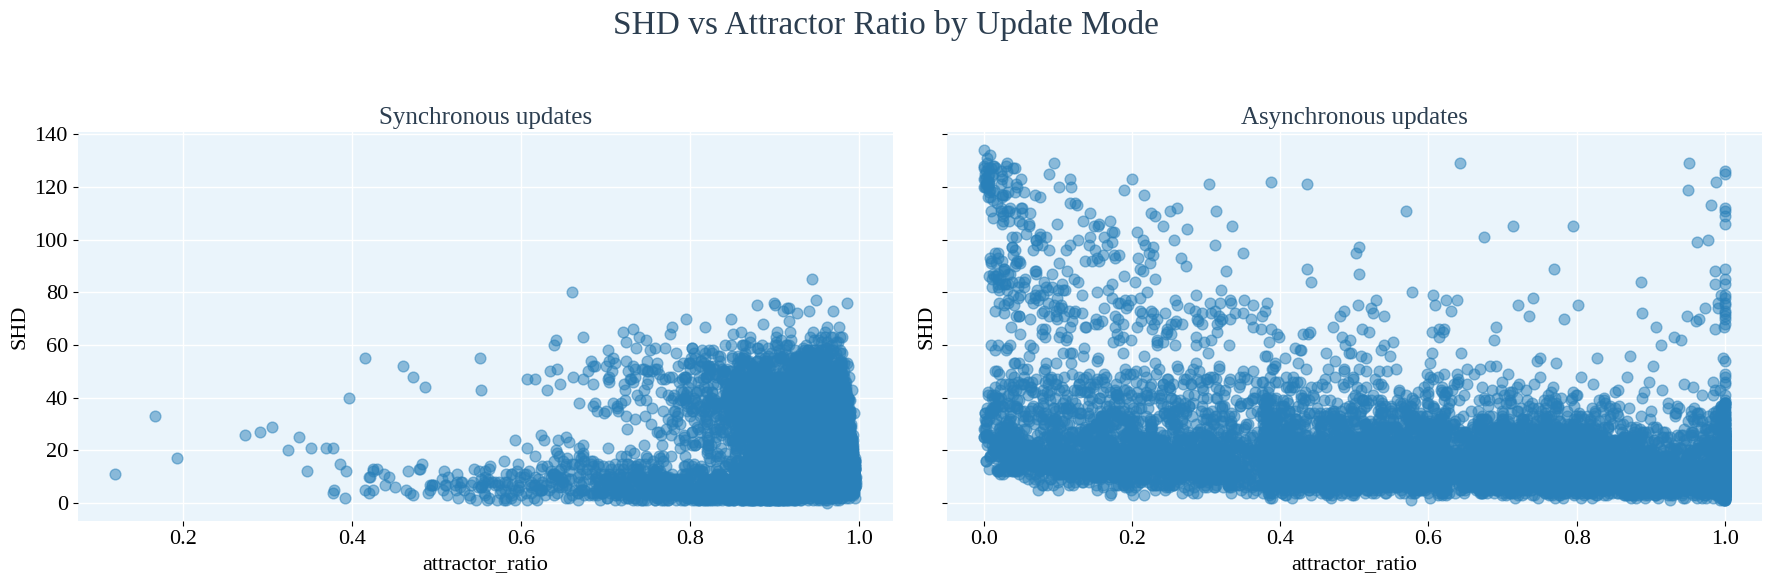

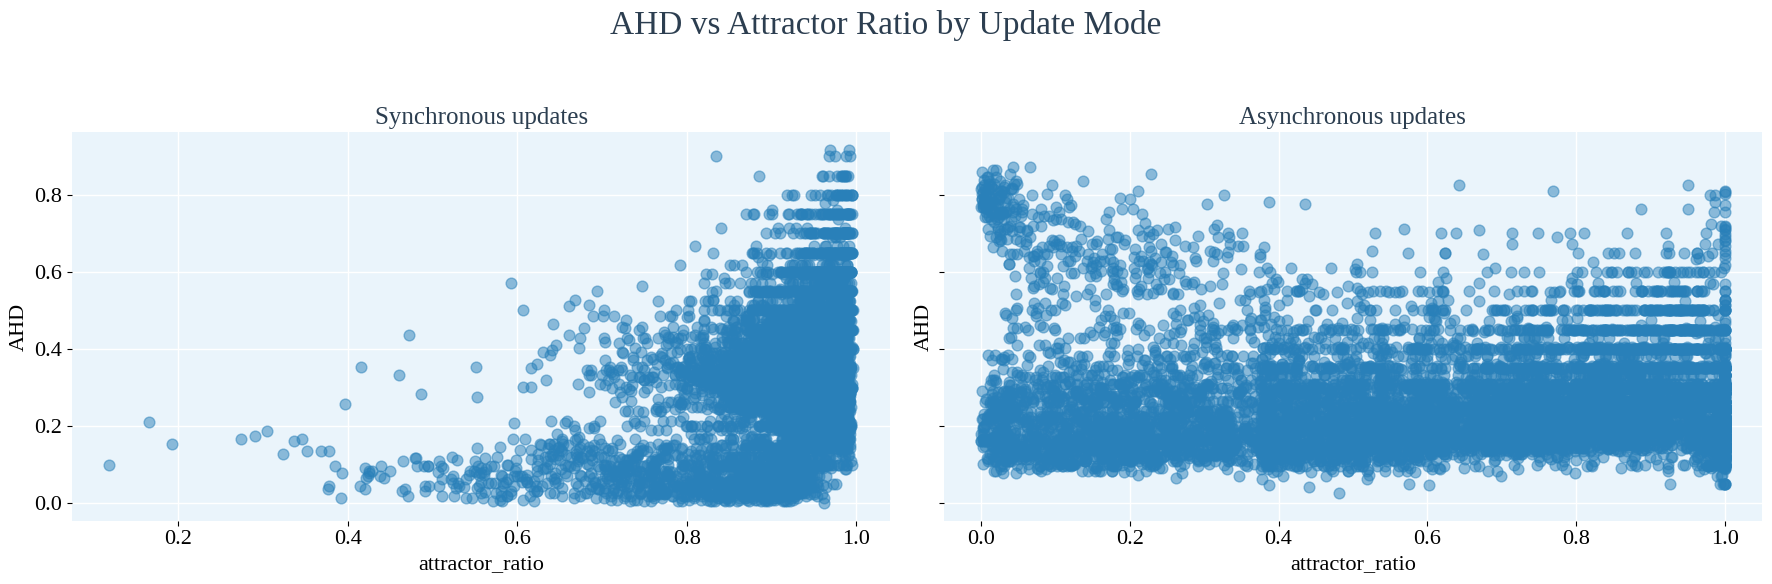

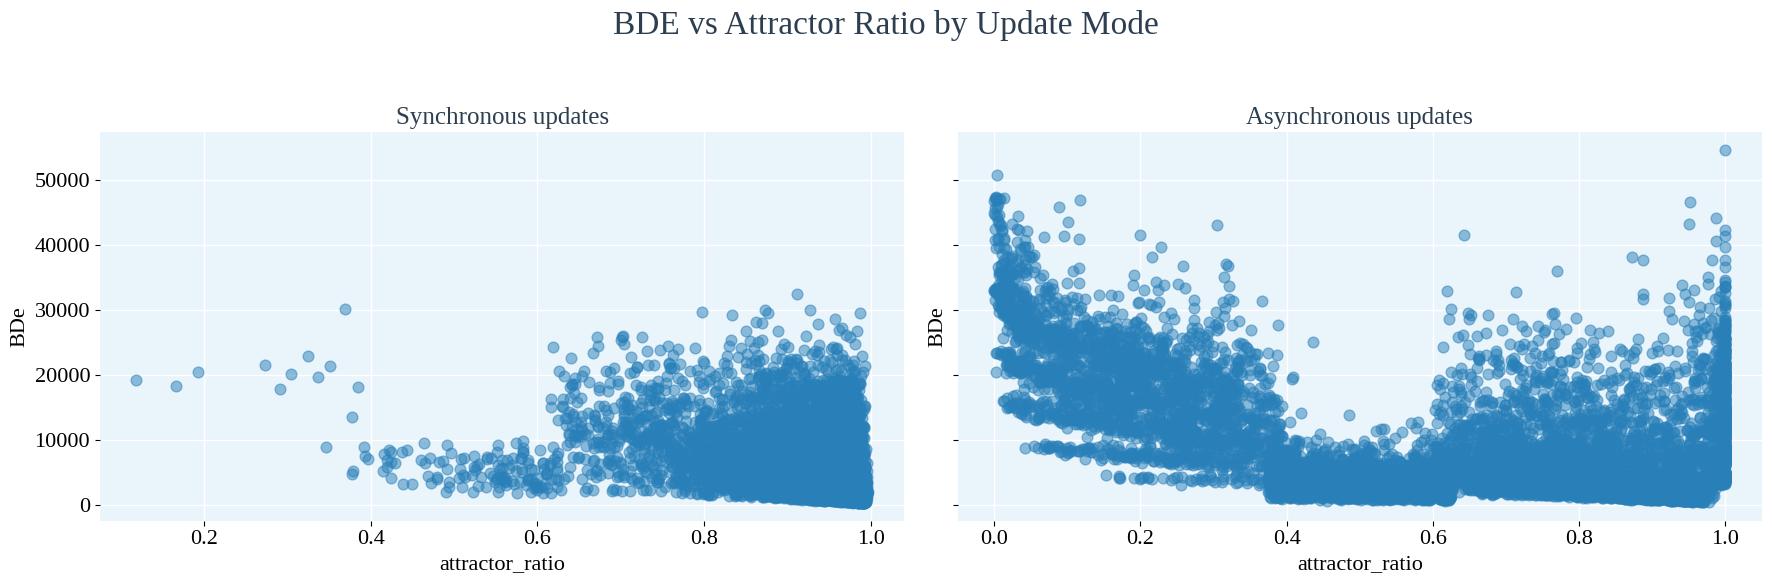

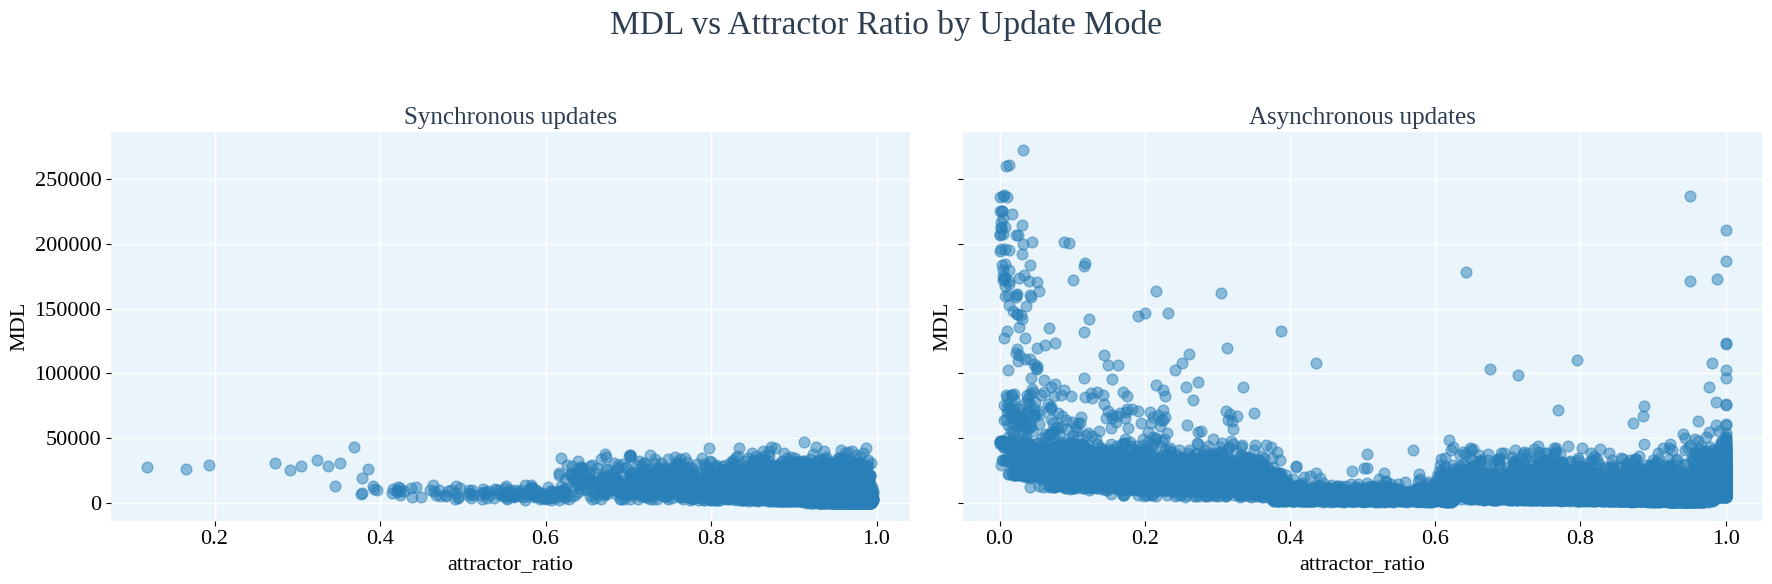

In [6]:
category_colors = ['#C0392B', '#2980B9', '#27AE60', '#F4D03F', '#8E44AD']

plot_scatter_subplots(df1, x='attractor_ratio', y='SHD', title='SHD vs Attractor Ratio by Update Mode')
plot_scatter_subplots(df1, x='attractor_ratio', y='AHD', title='AHD vs Attractor Ratio by Update Mode')
plot_scatter_subplots(df1, x='attractor_ratio', y='BDe', title='BDE vs Attractor Ratio by Update Mode')
plot_scatter_subplots(df1, x='attractor_ratio', y='MDL', title='MDL vs Attractor Ratio by Update Mode')

##### Results:

* In the **SHD plots**, under **synchronous updates**, most points are clustered at **high attractor ratios (>0.6)**, with SHD ranging broadly from **0 to 80**, reflecting the substantial structural error associated with attractor-dominated datasets. In contrast, **asynchronous updates** show attractor ratios spanning the full range, but SHD is generally much lower for low attractor ratio trajectories, increasing gradually up to **~40**, confirming that asynchronous dynamics produce more informative trajectories.
* For **AHD**, synchronous updates again concentrate at **attractor ratios >0.6**, with AHD ranging between **0.1–0.8**, whereas asynchronous updates cover the full attractor range but exhibit a dense cluster near **0–0.5**, indicating overall lower adjacency errors compared to synchronous dynamics.
* For **BDe**, synchronous updates concentrate mostly at **attractor ratios >0.6, with BDe ranging between 0.0-2500**. In asynchronous updates, however, a downward trend in BDe can be observed for the atraktor_ratio range of 0.0-0.4. After that, most of the values ​​accumulate close to zero.
* For **MDE**, in synchronous updates attractor ratio were >0.4 and values of MDL were ranges between 0-50000, for asynchronous attractor ratio were spanning the full range and MDL were mostly ranging between 0.0-100000.

Together, these scatter plots visually confirm our earlier findings: **high attractor ratios are associated with greater reconstruction errors**, and the **update mode strongly shapes the distribution of errors**, with asynchronous updates producing generally more accurate reconstructions. These visualizations provide a bridge to investigating **which factors influence attractor prevalence**, a key driver of reconstruction difficulty.

**This observation motivates the next step of our study: since attractor ratio is a key driver of reconstruction error, we now investigate which network- and data-generating factors determine the prevalence of attractor states in Boolean network trajectories.**

##### 1. Relation Between Trajectory Length and Entering Attractors

**Objective.**
To characterize how trajectory length is related to the probability of entering attractors as a function of network size and dynamics.

**Experimental design.**

- The target attractor proportion is **not controlled**; trajectories evolve naturally.
- Trajectory lengths are varied in increments proportional to network size:
    - from 10 steps to 50 by 10
- Networks are grouped by size (from 4 to 16 nodes, in steps of two).
- The number of parents per node is randomly chosen from set of $\{1,2,3\}$ to avoid conditioning results on a fixed connectivity pattern.

**Measured quantities.**

- Probability of reaching an attractor as a function of trajectory length.
- How different groups (below TODO - inner link) differ in in this probability.

**Rationale.**
Attractor entry is an emergent property of the dynamics. Controlling it directly is undesirable, as it would introduce selection bias. This experiment instead characterizes the **natural scaling behavior** of Boolean network dynamics.


(<Figure size 1300x500 with 1 Axes>,
 <Axes: title={'center': 'Asynchronous: Attractor Ratio vs Trajectory Length\nGrouped by num_nodes'}, xlabel='trajectory_length', ylabel='attractor_ratio'>)

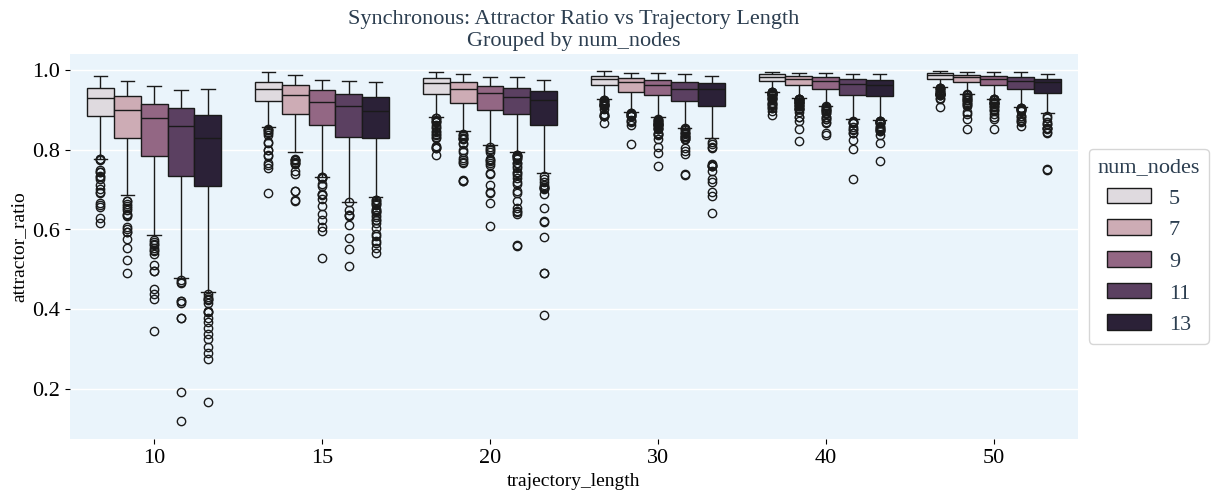

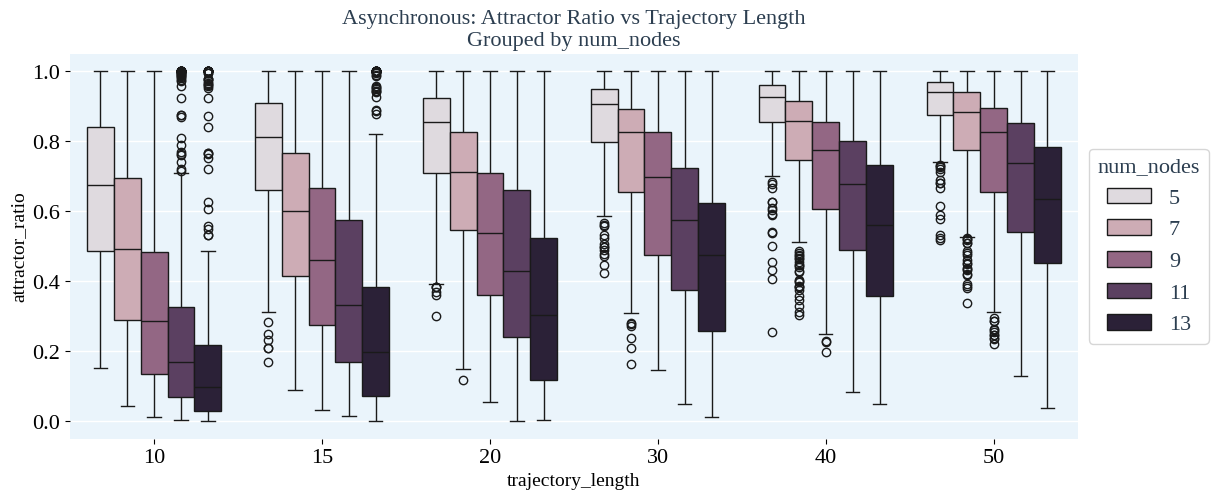

In [7]:
df_synchronous = df1[df1["update_mode"]=="synchronous"]
df_asynchronous = df1[df1["update_mode"]=="asynchronous"]

# Boxplot grouped by num_nodes synchronous
plot_boxplot(df_synchronous, x='trajectory_length', y='attractor_ratio', hue='num_nodes',
             title='Synchronous: Attractor Ratio vs Trajectory Length\nGrouped by num_nodes')
# Boxplot grouped by num_nodes synchronous
plot_boxplot(df_asynchronous, x='trajectory_length', y='attractor_ratio', hue='num_nodes',
             title='Asynchronous: Attractor Ratio vs Trajectory Length\nGrouped by num_nodes')

### Results

To further explore the factors influencing attractor prevalence, we generated boxplots of **attractor ratio versus trajectory length**, grouped by **network size (num_nodes)**, separately for **synchronous** and **asynchronous** updates.

* **Synchronous updates:** attractor ratios are generally higher across all trajectory lengths, consistent with the expected behavior of synchronous Boolean networks, where simultaneous node updates tend to drive the system more quickly into attractor states.
* **Asynchronous updates:** attractor ratios are lower overall and more widely distributed, reflecting the increased variability and longer transient dynamics inherent to asynchronous update schemes.

Across both update modes, we observe consistent trends:

1. **Trajectory length effect:** attractor ratio tends to increase with longer trajectories.
2. **Network size effect:** attractor ratio tends to decrease as the number of nodes increases.

These observations visually confirm the patterns suggested by our regression and scatter plot analyses, providing an intuitive view of how **update mode, trajectory length, and network size jointly shape attractor prevalence** in simulated Boolean networks.

### Scaling Law Analysis: Normalizing Trajectory Length by Network Size

To systematically compare how trajectory length and network size jointly influence convergence, we introduced a **scaling metric**: the **scale_ratio**, defined as `trajectory_length / num_nodes`. This metric normalizes the simulation time by the network’s complexity, allowing us to identify a unified scaling behavior across different system sizes.

In [8]:
df_summary = (
    df
    .groupby(["trajectory_length", "num_nodes"])
    .agg(
        median_ar=("attractor_ratio", "median"),
        q25_ar=("attractor_ratio", lambda x: x.quantile(0.25)),
        mean_ar=("attractor_ratio", "mean"),
        std_ar=("attractor_ratio", "std"),
        n=("attractor_ratio", "size")
    )
    .reset_index()
)

df_summary["scale_ratio"] = (
    df_summary["trajectory_length"] / df_summary["num_nodes"]
)

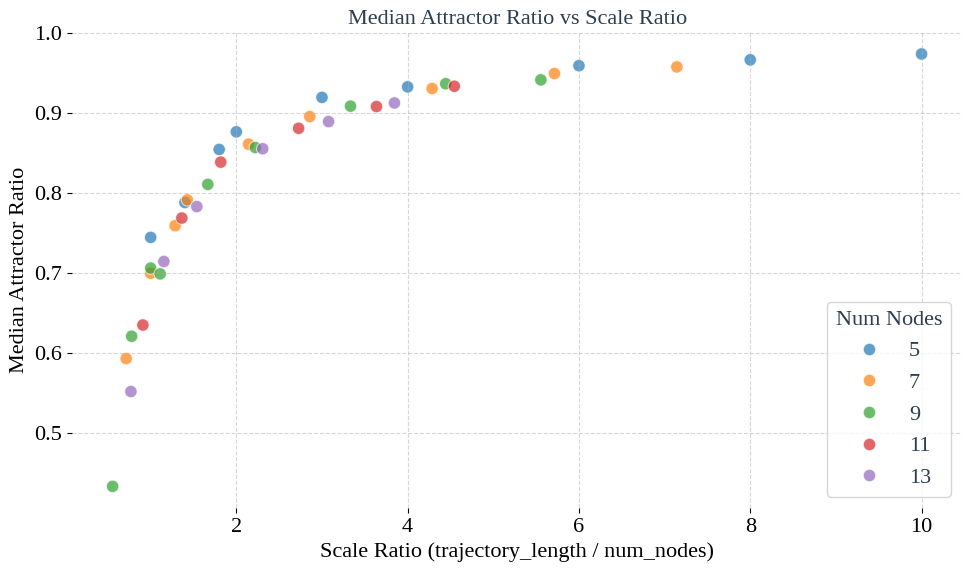

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_summary,
    x="scale_ratio",
    y="median_ar",
    hue="num_nodes",
    palette="tab10",
    s=80,       
    alpha=0.7   
)

plt.xlabel("Scale Ratio (trajectory_length / num_nodes)")
plt.ylabel("Median Attractor Ratio")
plt.title("Median Attractor Ratio vs Scale Ratio", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.5)


ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)

plt.legend(title="Num Nodes")
plt.tight_layout()
plt.show()


##### **Results:**
We could notice that **the lower scale ratio, the lower median attractor ratio**. This means that there is a significant relationship between the **structure of the Boolean network** on the basis of which we create our trajectory.

### Experiment 2

In [10]:
# Adjust data
## Add results from part 1
### Create new df for reproducibility 
df_series = df.copy()
### dropping values < threshold
df_series['scale'] = df_series["trajectory_length"] / df_series["num_nodes"]
df_series = df_series[df_series['scale'] < 1.5]
### dropping sets that are meaningles
df_series = df_series[
    (df_series["trajectory_length"] / df_series["sampling_frequency"]) > 1
]
## Add ACF and ESS information 
df_series = analyze_datasets_from_index(df_series, 'condition_id_name', DATASET_1_PATH, 1)

# merge 
df_series

[Progress] 1/8040 conditions completed (0.0%)
[Progress] 2/8040 conditions completed (0.0%)
[Progress] 3/8040 conditions completed (0.0%)
[Progress] 4/8040 conditions completed (0.0%)
[Progress] 5/8040 conditions completed (0.1%)
[Progress] 6/8040 conditions completed (0.1%)
[Progress] 7/8040 conditions completed (0.1%)
[Progress] 8/8040 conditions completed (0.1%)
[Progress] 9/8040 conditions completed (0.1%)
[Progress] 10/8040 conditions completed (0.1%)
[Progress] 11/8040 conditions completed (0.1%)
[Progress] 12/8040 conditions completed (0.1%)
[Progress] 13/8040 conditions completed (0.2%)
[Progress] 14/8040 conditions completed (0.2%)
[Progress] 15/8040 conditions completed (0.2%)
[Progress] 16/8040 conditions completed (0.2%)
[Progress] 17/8040 conditions completed (0.2%)
[Progress] 18/8040 conditions completed (0.2%)
[Progress] 19/8040 conditions completed (0.2%)
[Progress] 20/8040 conditions completed (0.2%)
[Progress] 21/8040 conditions completed (0.3%)
[Progress] 22/8040 con

,condition_id_num,dataset_succeeded,attractor_ratio,TP,FP,FN,f1,accuracy,precision,recall,...,trajectory_length,n_trajectories,sampling_frequency,score_function,n_parents_per_node,rep_id,condition_id_name,scale,mean_lag1_acf,mean_ess
0,10800,True,0.560909,20.0,7.0,1.0,0.833333,0.927273,0.740741,0.952381,...,10,110,1,MDL,"[1, 2, 3]",0,10800,0.909091,0.259213,767.688776
1,10801,True,0.551818,19.0,7.0,2.0,0.808511,0.918182,0.730769,0.904762,...,10,110,1,MDL,"[1, 2, 3]",1,10801,0.909091,0.411973,643.792302
2,10802,False,0.717879,15.0,14.0,4.0,0.625000,0.836364,0.517241,0.789474,...,10,110,1,MDL,"[1, 2, 3]",2,10802,0.909091,0.182934,2460.970075
3,10803,True,0.599091,17.0,8.0,2.0,0.772727,0.909091,0.680000,0.894737,...,10,110,1,MDL,"[1, 2, 3]",3,10803,0.909091,0.470910,608.891975
4,10804,False,0.704545,17.0,10.0,1.0,0.755556,0.900000,0.629630,0.944444,...,10,110,1,MDL,"[1, 2, 3]",4,10804,0.909091,-0.219593,3258.750781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,9295,True,0.493961,11.0,2.0,4.0,0.785714,0.916667,0.846154,0.733333,...,10,90,5,BDE,"[1, 2, 3]",25,9295,1.111111,0.714444,374.285498
8036,9296,False,0.639372,13.0,10.0,3.0,0.666667,0.819444,0.565217,0.812500,...,10,90,5,BDE,"[1, 2, 3]",26,9296,1.111111,0.603387,1226.775166
8037,9297,False,0.369163,19.0,8.0,2.0,0.791667,0.861111,0.703704,0.904762,...,10,90,5,BDE,"[1, 2, 3]",27,9297,1.111111,0.610071,1218.849190
8038,9298,False,0.650564,17.0,8.0,2.0,0.772727,0.861111,0.680000,0.894737,...,10,90,5,BDE,"[1, 2, 3]",28,9298,1.111111,0.575732,1261.056736


#### Part 0: Sample Size Adequacy and Statistical Validity 

Before applying any statistical tests, we verify that the number of available observations remains sufficient after filtering the data. In particular, we removed:

* configurations with scale ratio below 1.5,
* cases without effective subsampling (single-sample trajectories).

After this filtering step, we assess whether the remaining sample sizes are still representative.

The resulting sample counts are as follows:

* **sampling frequency × number of nodes**: at least 240 observations per group, and up to 480 in larger configurations,
* **scoring function × number of nodes**: between 540 and 1140 observations, depending on the condition.

These sample sizes are quite large, and still have all repetitions for every experiment.

In [11]:
# sampling frequency vs num_nodes
table = pd.pivot_table(
    df_series,
    index='sampling_frequency',
    columns='num_nodes',
    aggfunc='size',
    fill_value=0
)
table

num_nodes,5,7,9,11,13
sampling_frequency,,,,,
1,240,480,480,240,240
2,240,480,480,240,240
3,240,480,480,240,240
4,240,480,480,240,240
5,120,360,360,240,240


In [12]:
# score function vs num_nodes
table = pd.pivot_table(
    df_series,
    index='score_function',
    columns='num_nodes',
    aggfunc='size',
    fill_value=0
)
table

num_nodes,5,7,9,11,13
score_function,,,,,
BDE,540,1140,1140,600,600
MDL,540,1140,1140,600,600


#### Part 1: ESS and ACF vs Sampling Frequency 

This section analyzes how sampling frequency affects temporal dependence in the generated datasets. We focus on two diagnostics:
* lag-1 autocorrelation (ACF),
* effective sample size (ESS).

##### Methodology 

We analyze the **mean lag-1 autocorrelation**, denoted `mean_lag1_acf`, which measures dependence between consecutive sampled time points. Lag 1 is chosen because it captures correlation between two adjacent time points.  

ESS is computed to quantify the amount of effectively independent information contained in the sampled trajectories. Higher ESS should bring more information to model training and improve reconstruction quality. 

---

##### Results: Lag-1 Autocorrelation (ACF)

For **synchronous update**, the distribution of `mean_lag1_acf` is centered close to zero across all sampling frequencies and network sizes. No systematic trend with respect to sampling frequency is observed. This behavior is expected, as synchronous dynamics define a deterministic mapping between states; subsampling does not substantially alter short-range temporal dependence.

For **asynchronous update**, we observe:

* a clear decrease in lag-1 autocorrelation when increasing sampling frequency from 1 to 3,
* a weaker but still noticeable change between frequencies 1 and 4,
* a potential degradation or saturation between frequencies 4 and 5.

These observations suggest that subsampling reduces short-range dependence in asynchronous trajectories up to a point, beyond which additional subsampling start to increase ACF. The non-monotonic behavior at higher sampling frequencies requires further statistical testing to assess significance.

---

##### Results: Effective Sample Size (ESS) 

For **synchronous update**, ESS increases clearly with sampling frequency across all network sizes. This indicates that subsampling effectively reduces redundancy in deterministic dynamics. 

For **asynchronous update**, the pattern is less clear:

* ESS values are substantially lower than in the synchronous case,
* increases in sampling frequency do not translate into uniform gains in ESS,
* ESS appears to depend jointly on sampling frequency and network size.

This suggests that stochastic update dynamics introduce long-range temporal correlations that are not fully mitigated by simple subsampling. s a result, sampling frequency alone is insufficient to ensure an increase in ESS in asynchronous trajectories.

##### Conclusion
For both **synchronous** and **asynchronous** update there is no clear relation between ESS and ACF. In next parts we will need to examine them independently. 

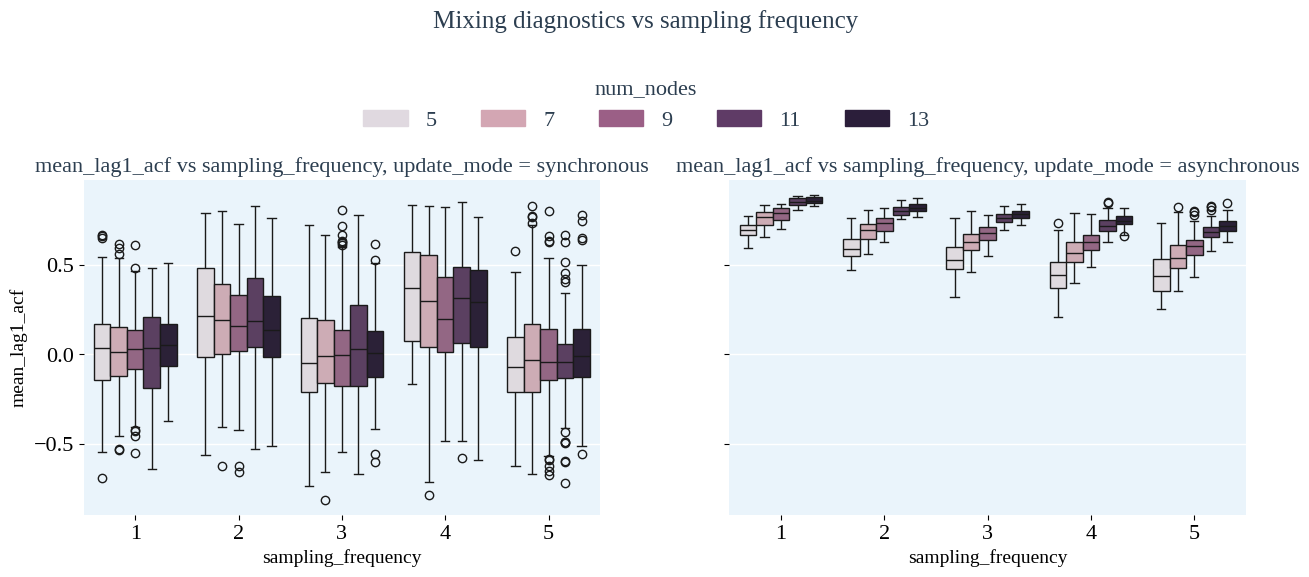

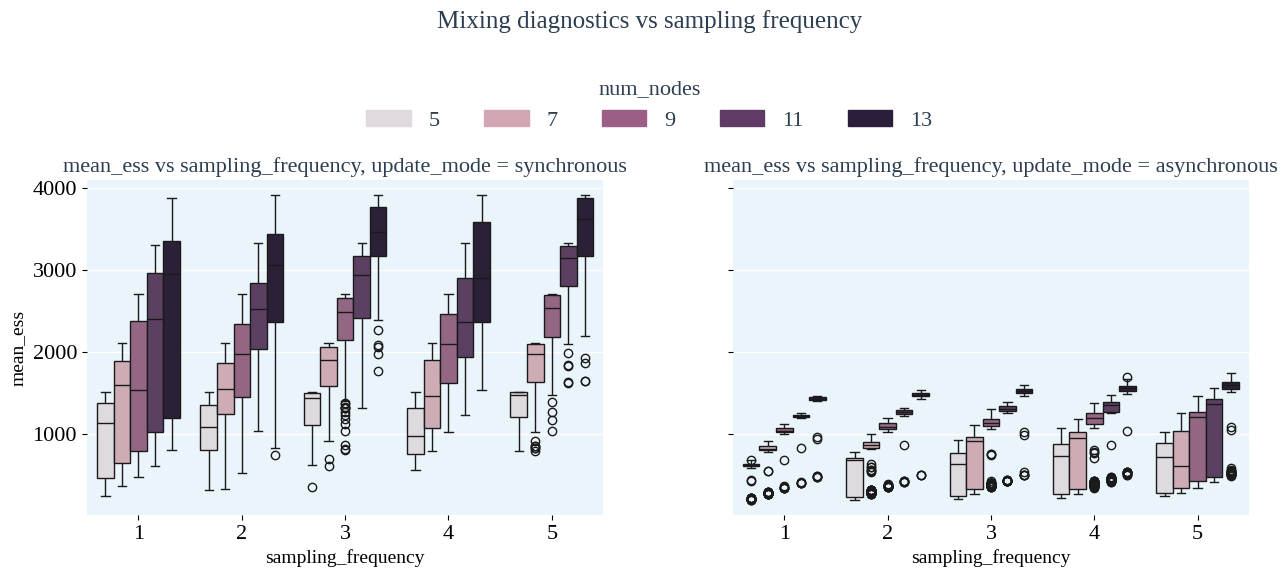

In [13]:

plot_grouped_boxplots(
    df=df_series,
    group_col=None,                       # ← kluczowe
    x_col="sampling_frequency",
    y_cols=["mean_lag1_acf", "mean_ess"],
    hue_col="num_nodes",
    facet_col="update_mode",              # ← porównanie sync vs async
    facet_levels=["synchronous", "asynchronous"],
    main_title="Mixing diagnostics vs sampling frequency",
)




#### Analysis 2: Reconstruction quality vs sampling frequency

##### Methodology

In this analysis, we study the relationship between **sampling frequency** and **model reconstruction quality**, measured using the structural accuracy metrics **AHD** and **SID**.

The objective is to determine how changes in sampling frequency affect the quality of inferred network structures.

---

##### Analysis: Synchronous update 

For the **synchronous update mode**, a clear pattern is observed in both reconstruction metrics.

As shown in:

* **AHD vs sampling frequency** plots (top row, synchronous panels),
* **SID vs sampling frequency** plots (middle upper row, synchronous panels),

the smallest values of both AHD and SID are obtained for **sampling frequency = 1**, across all network sizes and for both MDL and BDe scoring functions. Increasing the sampling frequency leads to a systematic degradation of reconstruction quality.

Given the consistency of this effect across metrics, scoring functions, and network sizes, no further statistical testing is required for the synchronous case.

##### Analysis: Asynchronous update

For the **asynchronous update mode**, the behavior is not clear.

From the corresponding plots:

* **AHD vs sampling frequency** (middle lower row, asynchronous panels),
* **SID vs sampling frequency** (bottom row, asynchronous panels),

we observe that reconstruction quality generally improves when increasing sampling frequency from 1 to approximately 3. Beyond this point improvement become inconsistent across network sizes and score functions.

This lack of monotonicity indicates that, in the asynchronous case, the relationship between sampling frequency and reconstruction quality is mediated by additional factors, such as long-range temporal dependence and network size. Consequently, inferential statistical tests are required to assess the significance of these trends.

---

##### Conclusions

We find a clear relationship between **sampling frequency** and **model reconstruction quality**, but this relationship is different for synchronous and asynchronous case:

* For **synchronous dynamics**, the optimal choice is **sampling frequency = 1**, as any subsampling leads to a consistent loss of structural and causal accuracy.
* For **asynchronous dynamics**, reconstruction quality generally improves with subsampling up to a moderate frequency (around 3), but no single optimal value can be identified without further statistical testing.

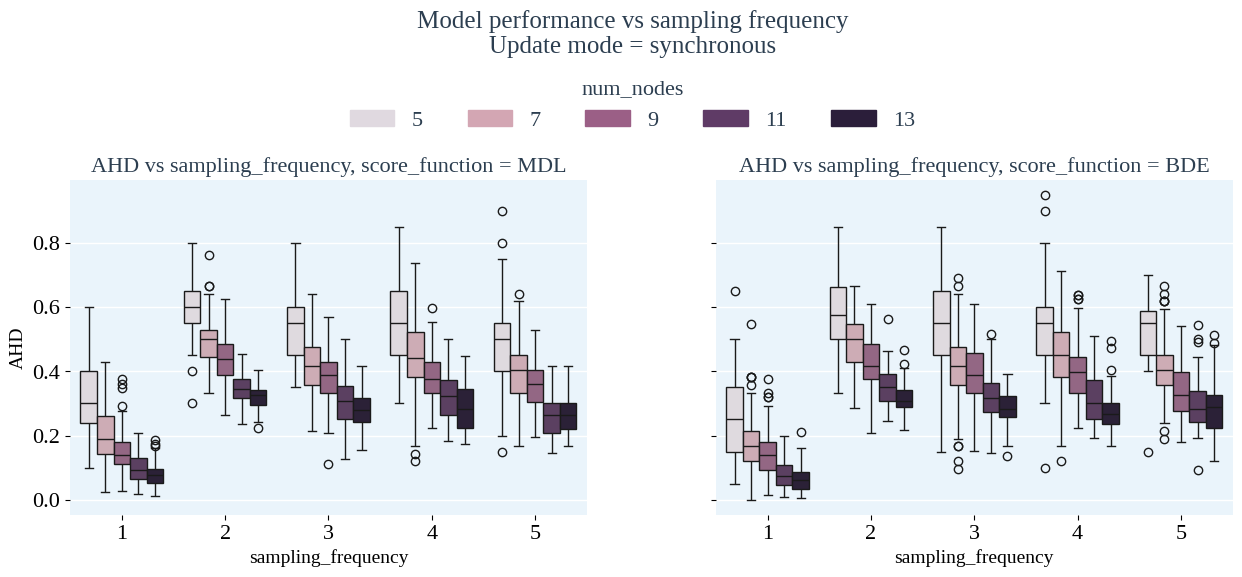

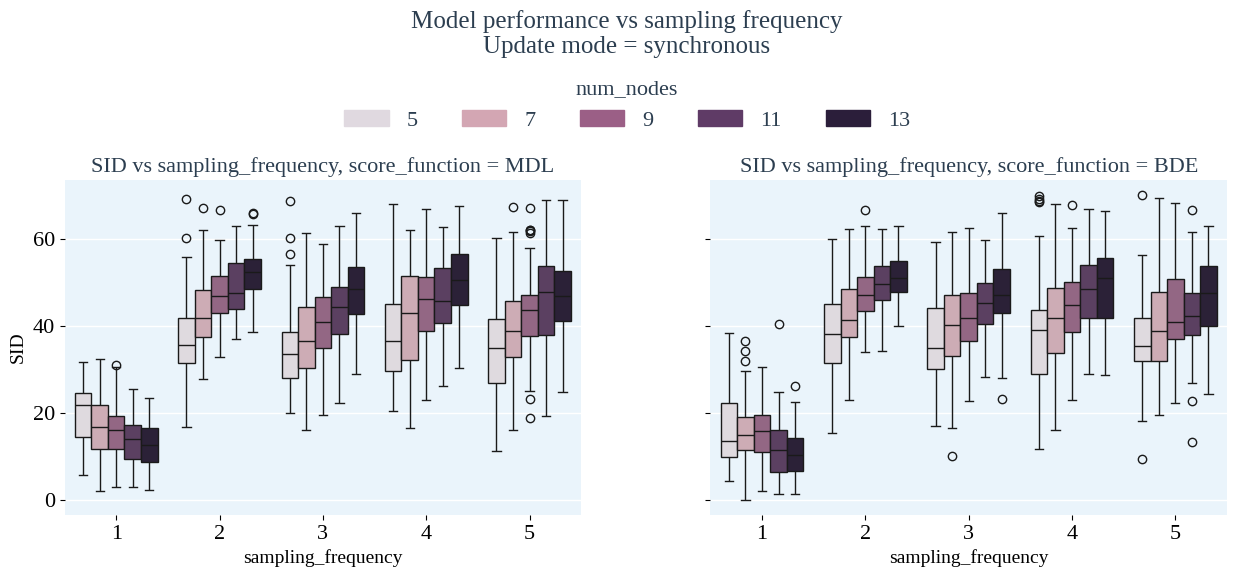

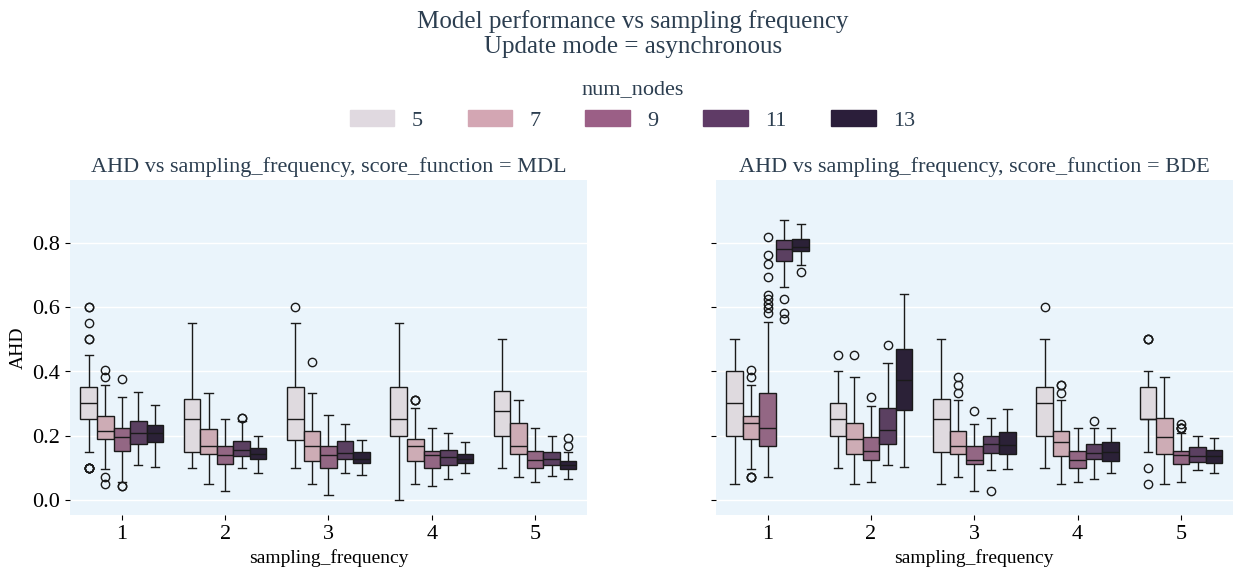

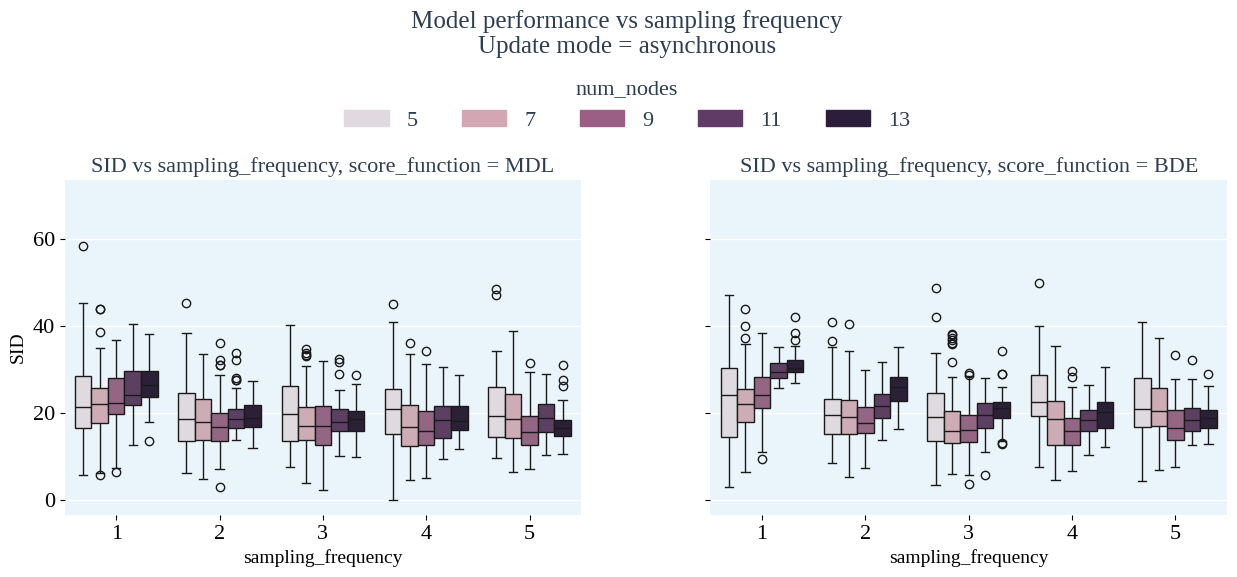

In [14]:
plot_grouped_boxplots(
    df=df_series,
    group_col="update_mode",
    x_col="sampling_frequency",
    y_cols=["AHD", "SID"],
    hue_col="num_nodes",
    facet_col="score_function",
    facet_levels=["MDL", "BDE"],
    main_title="Model performance vs sampling frequency",
    group_title_fmt="Update mode = {}"
)



#### Part 3 – Spearman Correlation Analysis

##### Methodology

The main objective of this analysis is to assess whether properties of a data: **ESS** and **lag-1 ACF**, are associated with **model reconstruction quality**, measured using AHD and SID.

we compute **Spearman rank correlations** between:

* ESS and reconstruction metrics,
* lag-1 ACF and reconstruction metrics,

separately for groups defined by:

* update mode,
* score function,
* number of nodes.
* sampling_frequency

After prior filtering, each group contains between **60 and 120 observations**, which is sufficient for stable estimation of Spearman correlations if $\rho \geq 0.4$ (see Bonett & Wright, 2000).  Correlations are presented as heatmaps, independently for each combination of `num_nodes` and `score_function` and `update_mode`.

This analysis is conducted separately for ESS and ACF, as results from part 1 indicate that these quantities are not interchangeable and may capture different aspects of temporal dependence.

---

##### Results: ESS

The results for ESS are summarized in the **ESS–AHD** and **ESS–SID** heatmaps.

For the **synchronous update mode** (top heatmaps), Spearman correlation coefficients are close to zero across all network sizes and both scoring functions. No consistent monotonic relationship between ESS and reconstruction quality is observed for either AHD or SID.

In contrast, for the **asynchronous update mode** (bottom heatmaps), a clear negative trend is visible:

* ESS exhibits moderate negative correlations with AHD and SID,
* correlations are stronger for larger networks, ($\geq 9$)
* several correlations (3/12) are statistically significant.

This may suggest that, in asynchronous systems, higher effective sample size is associated with improved reconstruction quality, whereas in synchronous systems ESS does not appear to be a limiting factor. 

---

##### Results: Lag-1 Autocorrelation (ACF)

The analysis of lag-1 ACF reveals a complementary pattern.

For **synchronous update**, correlations between ACF and reconstruction metrics remain weak and inconsistent across all configurations, confirming that short-range autocorrelation does not meaningfully affect reconstruction quality in this regime.

For **asynchronous update**, we observe statistically significant correlations in selected configurations with larger BN (9, 11, 13):

* a significant correlation between ACF and **AHD** for the **MDL** score,
* a significant correlation between ACF and **SID** for the **BDe** score.

These effects are visible in the asynchronous ACF heatmaps and suggest that 
dependence on neighborhood samples influence negatively reconstruction quality.

---

##### Conclusions

We conclude that:

* There is **no meaningful monotonic relationship** between ESS or ACF and reconstruction quality in synchronous systems.
* In asynchronous systems, **higher ESS is may be associated with improved reconstruction quality**.
* In asynchronous systems, **Lag-1 ACF influences negatively reconstruction quality**

##### Reference

Bonett, D. G., & Wright, T. A. (2000). Sample size requirements for estimating Pearson, Kendall and Spearman correlations. Psychometrika, 65, 23–28.

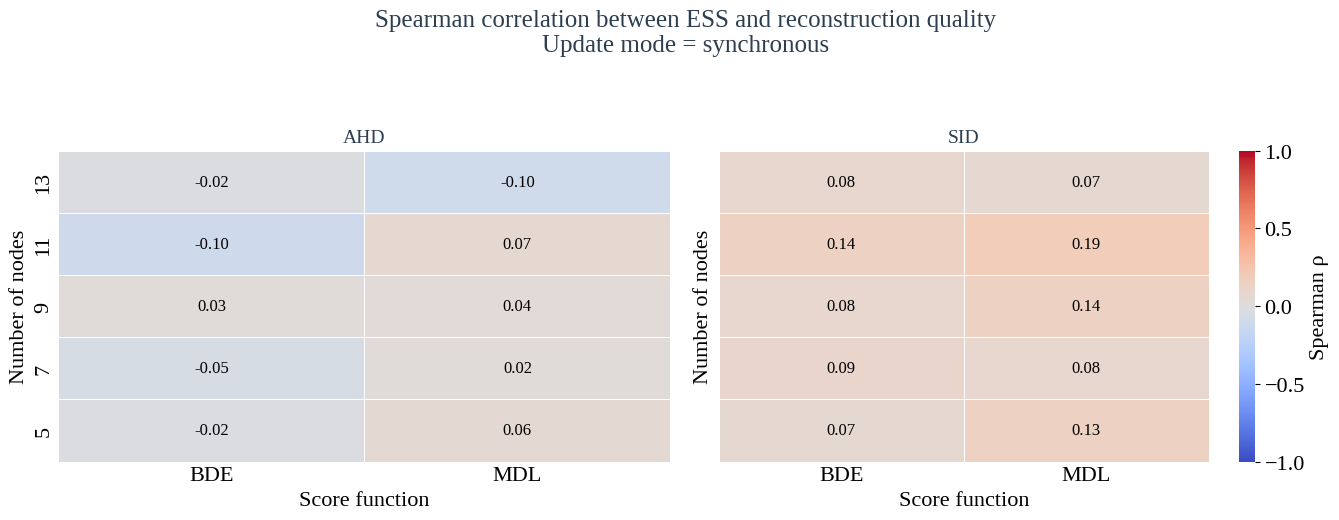

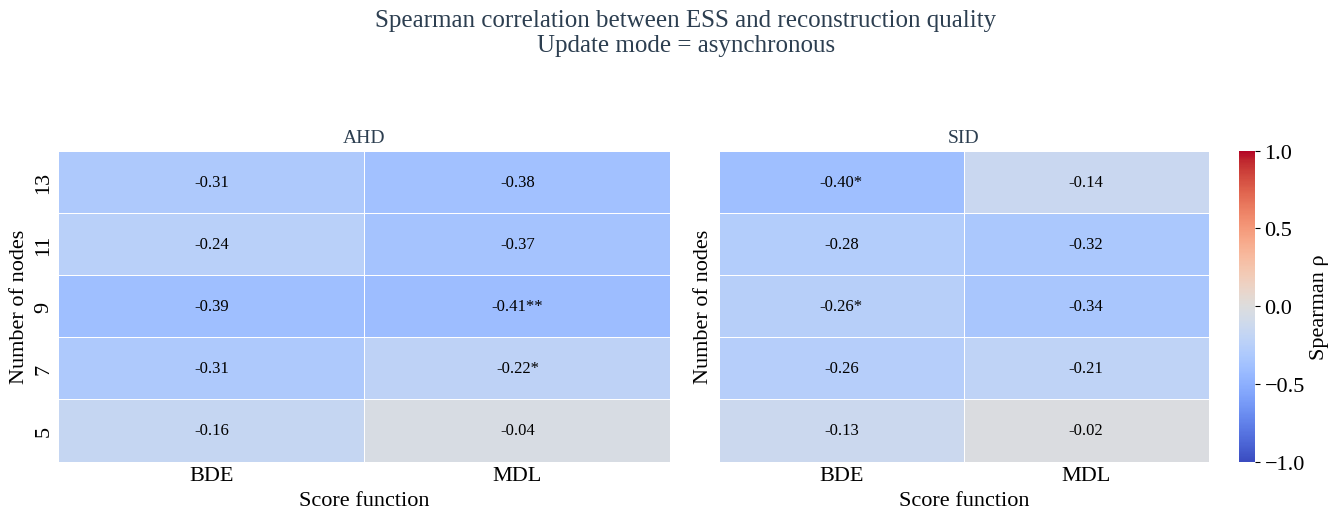

<Figure size 640x480 with 0 Axes>

In [15]:
group_cols = ["update_mode", "score_function", "num_nodes", "sampling_frequency"]

df_spearman = compute_spearman_table(
    df_series,
    metrics=["AHD", "SID"],
    group_cols = group_cols,
    ess_col= "mean_ess"
)



for update_mode in ["synchronous", "asynchronous"]:

    fig, axes = plt.subplots(
        1, 2,
        figsize=(14, 5),
        sharey=True
    )

    plot_spearman_heatmap(
        df_spearman,
        metric="AHD",
        update_mode=update_mode,
        num_nodes_order=sorted(df_series["num_nodes"].unique(), reverse=True),
        ax=axes[0],
        cbar=False
    )

    plot_spearman_heatmap(
        df_spearman,
        metric="SID",
        update_mode=update_mode,
        num_nodes_order=sorted(df_series["num_nodes"].unique(), reverse=True),
        ax=axes[1],
        cbar=True
    )

    fig.suptitle(
        "Spearman correlation between ESS and reconstruction quality\n"
        f"Update mode = {update_mode}",
        fontsize=18,
        y=1.05
    )

    plt.tight_layout()
    plt.show()

plt.tight_layout()
plt.show()



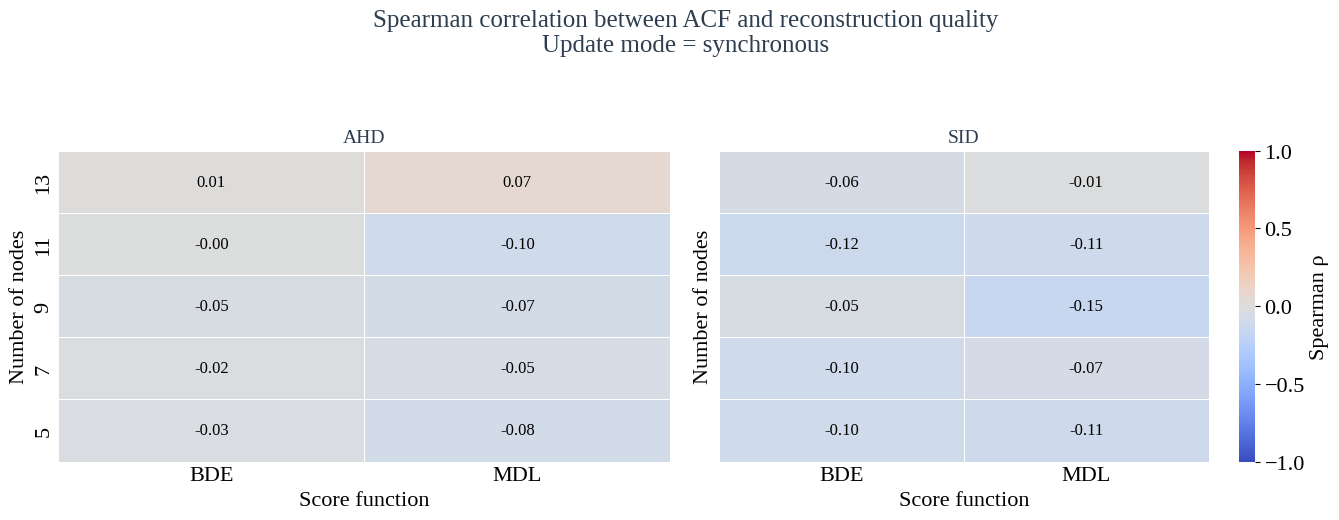

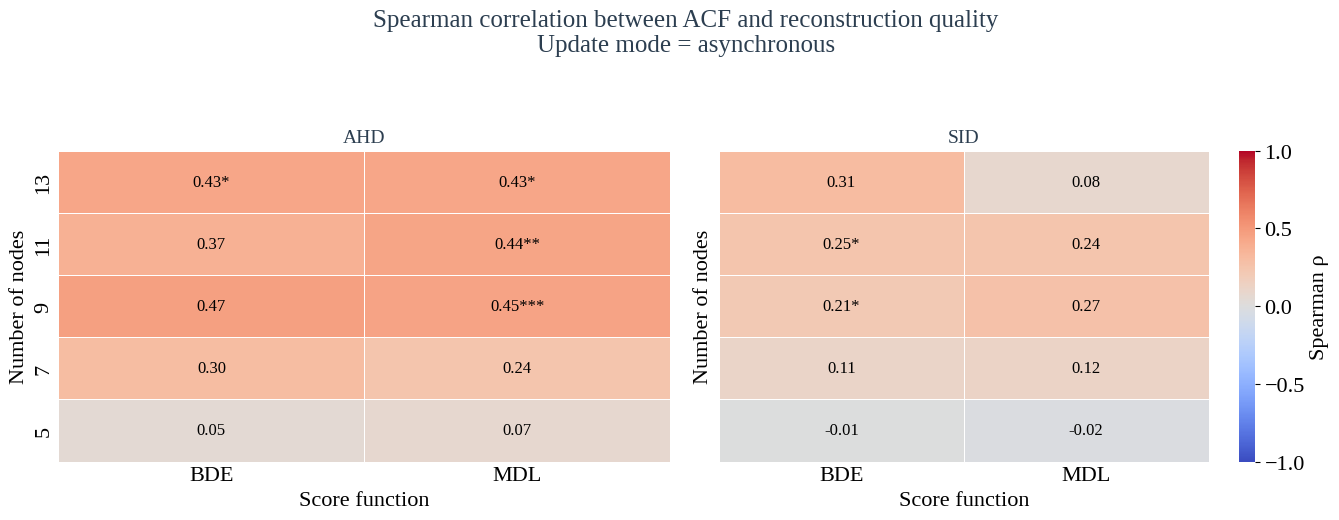

<Figure size 640x480 with 0 Axes>

In [16]:
group_cols = ["update_mode", "score_function", "num_nodes", "sampling_frequency"]

df_spearman = compute_spearman_table(
    df_series,
    metrics=["AHD", "SID"],
    group_cols = group_cols,
    ess_col= "mean_lag1_acf"
)


counts = (
    df_series
    .groupby(group_cols)
    .size()
    .reset_index(name="n_rows")
)
counts 

for update_mode in ["synchronous", "asynchronous"]:

    fig, axes = plt.subplots(
        1, 2,
        figsize=(14, 5),
        sharey=True
    )

    plot_spearman_heatmap(
        df_spearman,
        metric="AHD",
        update_mode=update_mode,
        num_nodes_order=sorted(df_series["num_nodes"].unique(), reverse=True),
        ax=axes[0],
        cbar=False
    )

    plot_spearman_heatmap(
        df_spearman,
        metric="SID",
        update_mode=update_mode,
        num_nodes_order=sorted(df_series["num_nodes"].unique(), reverse=True),
        ax=axes[1],
        cbar=True
    )

    fig.suptitle(
        "Spearman correlation between ACF and reconstruction quality\n"
        f"Update mode = {update_mode}",
        fontsize=18,
        y=1.05
    )

    plt.tight_layout()
    plt.show()

plt.tight_layout()
plt.show()



In [17]:
counts = (
    df_series
    .groupby(group_cols)
    .size()
    .reset_index(name="n_rows")
)
counts 

,update_mode,score_function,num_nodes,sampling_frequency,n_rows
0,asynchronous,BDE,5,1,60
1,asynchronous,BDE,5,2,60
2,asynchronous,BDE,5,3,60
3,asynchronous,BDE,5,4,60
4,asynchronous,BDE,5,5,30
...,...,...,...,...,...
95,synchronous,MDL,13,1,60
96,synchronous,MDL,13,2,60
97,synchronous,MDL,13,3,60
98,synchronous,MDL,13,4,60




#### Part 4. Does increasing sampling frequency significantly improve median reconstruction quality?

##### Methodology

The objective of this analysis is to assess whether **increasing the sampling frequency (sampling factor)** leads to **statistically significant changes in the median values of reconstruction quality metrics** for AHD and SID.

The analysis is conducted **exclusively for the asynchronous update mode**, as in the synchronous setting the descriptive results clearly indicate that the best reconstruction quality is achieved for **sampling factor equal to 1**, making further statistical comparisons unnecessary.

To isolate the effect of sampling frequency, all statistical tests are performed **within homogeneous experimental groups**, defined by the following variables:

* update mode,
* score function,
* number of nodes.

For each group, **paired comparisons** are performed between consecutive sampling factors (1→2, 2→3, 3→4, 4→5). The analysis considers two reconstruction quality metrics:

* AHD,
* SID,

and two score functions:

* BDe,
* MDL.

Statistical significance of median differences is assessed using the **single (greater) Wilcoxon signed-rank test**.

Depending on the experimental condition, the number of paired observations equals **900, 1800, or 3600**, which allows the applied tests to be considered as having **high statistical power**.

The results are summarized in a heatmap that presents:

* the median difference between consecutive sampling factors,
* statistical significance levels for each comparison.

---

##### Analysis

For **BDe**, a **statistically significant improvement in reconstruction quality is observed for the transition from sampling factor 2 to 3**, indicating a meaningful change in the ranking of graph structures induced by this cost function. No further gains are observed for higher sampling factors.

In contrast, when using **MDL**, statistically significant differences are observed only for the  transition from **sampling factor 1 to 2**. 

Importantly, these effects reflect changes in the **values of the cost functions used to rank candidate graph structures**, rather than direct improvements in the reconstruction metrics themselves. The observed differences may arise from BDe and MDL different construction, and usage of prior information from BDe.


---

##### Recommended configuration

Based on the obtained results, the following recommendations can be formulated:

* **synchronous**:
  the optimal sampling factor is **3** (part 2)

* **BDe (asynchronous)**:
  the optimal sampling factor is **3**, we show that changes in direction (1-2-3) significantly increase reconstruction quality (AHD, SID). 

* **MDL (asynchronous)**:
  the optimal sampling factor is **2**, we show that changes in direction (1-2) significantly increase reconstruction quality (AHD, SID). 

Higher sampling factors does not bring any differences, to reconstruction quality, it may only reduce them. 

In [18]:
group_cols = ["update_mode", "score_function", "num_nodes"]
df_wilcoxon = compute_wilcoxon_table(
    df_series,
    metrics=["AHD", "SID"],
    group_cols=group_cols,
    transitions=[(1,2), (2,3), (3,4), (4,5)], #TODO - tutaj wstawic kolejnośc z jaką chcesz sprawdzać (20, 40) ...
    sf_col='sampling_frequency' #TODO - tutaj wstawić tą kolumne co masz stałą normalizacji 
)

df_wilcoxon['n_pairs']
df_wilcoxon



,metric,sf_from,sf_to,transition,n_pairs,wilcoxon_stat,p_value,median_diff,update_mode,score_function,num_nodes
0,AHD,1,2,1→2,1800,816147.0,1.849133e-26,-0.050000,asynchronous,BDE,5
1,AHD,2,3,2→3,1800,666709.0,1.449905e-03,0.000000,asynchronous,BDE,5
2,AHD,3,4,3→4,1800,413684.0,1.000000e+00,0.050000,asynchronous,BDE,5
3,AHD,4,5,4→5,900,192721.0,3.888873e-09,-0.050000,asynchronous,BDE,5
4,SID,1,2,1→2,1800,NaN,NaN,NaN,asynchronous,BDE,5
...,...,...,...,...,...,...,...,...,...,...,...
155,AHD,4,5,4→5,1800,982430.0,5.386245e-24,-0.019231,synchronous,MDL,13
156,SID,1,2,1→2,1800,0.0,1.000000e+00,39.171777,synchronous,MDL,13
157,SID,2,3,2→3,1800,1137545.0,4.606971e-50,-3.632954,synchronous,MDL,13
158,SID,3,4,3→4,1800,624218.0,1.000000e+00,2.430778,synchronous,MDL,13


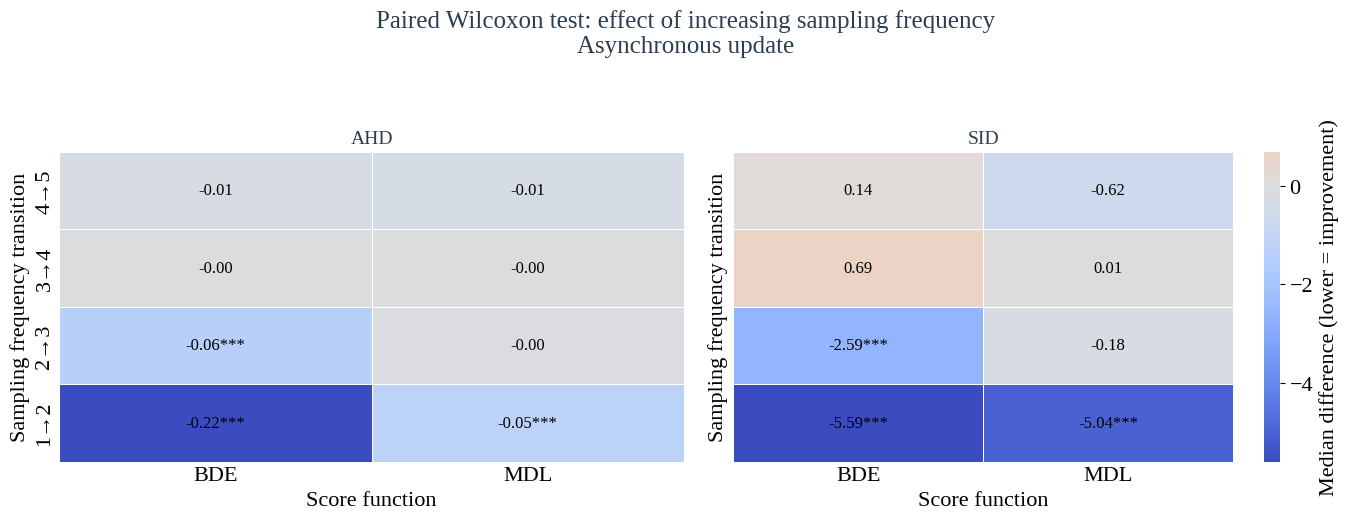

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

plot_wilcoxon_heatmap(
    df_wilcoxon,
    metric="AHD",
    update_mode="asynchronous",
    transitions_order=sorted(df_wilcoxon['transition'].unique(), reverse=True),
    ax=axes[0],
    cbar=False
)

plot_wilcoxon_heatmap(
    df_wilcoxon,
    metric="SID",
    update_mode="asynchronous",
    transitions_order=sorted(df_wilcoxon['transition'].unique(), reverse=True),
    ax=axes[1],
    cbar=True
)

fig.suptitle(
    "Paired Wilcoxon test: effect of increasing sampling frequency\n"
    "Asynchronous update",
    fontsize=18,
    y=1.05
)

plt.tight_layout()
plt.show()



### Experiment 3

#### Obserwacja trendu

#### Testy istotności

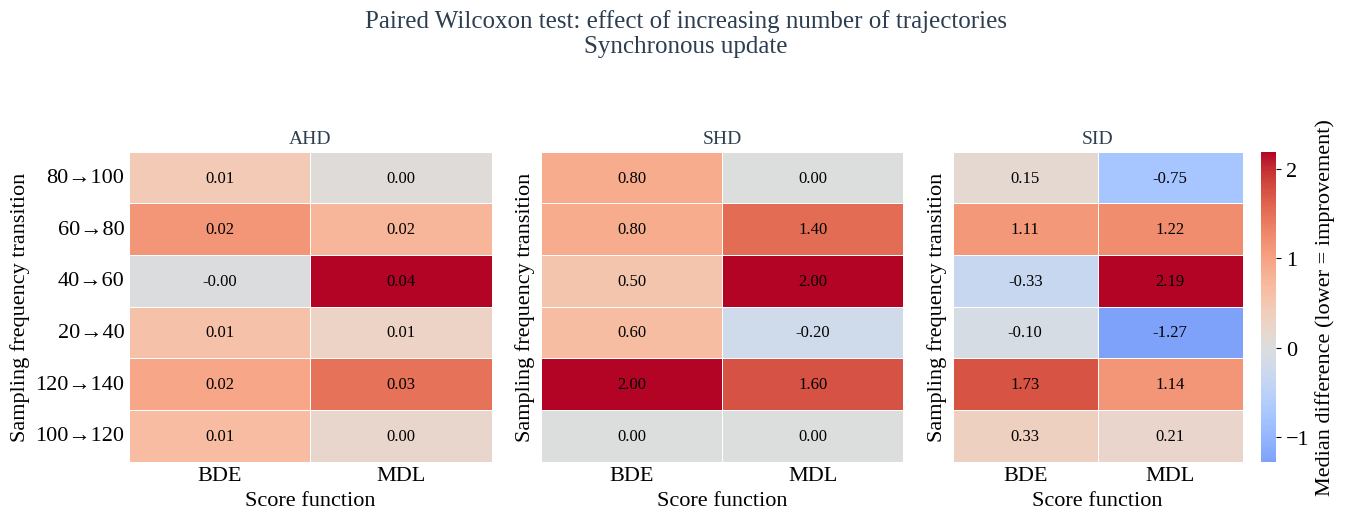

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

df_wilcoxon_s = compute_wilcoxon_table(
    dfs,
    metrics=["AHD", "SHD", "SID"],
    transitions=[(i*20, (i+1)*20) for i in range(1, 7)],
    group_cols=('num_nodes', 'update_mode', 'score_function'),
    sf_col='k_value' 
)
plot_wilcoxon_heatmap(
    df_wilcoxon_s,
    metric="AHD",
    update_mode="synchronous",
    transitions_order=sorted(df_wilcoxon_s['transition'].unique(), reverse=True),
    ax=axes[0],
    cbar=False
)

plot_wilcoxon_heatmap(
    df_wilcoxon_s,
    metric="SHD",
    update_mode="synchronous",
    transitions_order=sorted(df_wilcoxon_s['transition'].unique(), reverse=True),
    ax=axes[1],
    cbar=False
)

plot_wilcoxon_heatmap(
    df_wilcoxon_s,
    metric="SID",
    update_mode="synchronous",
    transitions_order=sorted(df_wilcoxon_s['transition'].unique(), reverse=True),
    ax=axes[2],
    cbar=True
)

fig.suptitle(
    "Paired Wilcoxon test: effect of increasing number of trajectories\n"
    "Synchronous update",
    fontsize=18,
    y=1.05
)

plt.tight_layout()
plt.show()


In [15]:
dfa

,condition_id_num,dataset_succeeded,attractor_ratio,TP,FP,FN,f1,accuracy,precision,recall,sensitivity,AHD,SHD,EHD,SID,log_likelihood,MDL,BDe,part_x,num_nodes,update_mode,trajectory_length,n_trajectories,sampling_frequency,score_function,n_parents_per_node,rep_id,condition_id_name,k_value,part_y
0,0,True,0.667692,4.0,1.0,5.0,0.571429,0.700000,0.800000,0.444444,0.444444,0.300000,6.0,5.0,25.899405,372.333209,408.874418,286.663496,1.0,5,asynchronous,4,25,4,MDL,"[1, 2, 3]",0,00000,20,1
1,1,False,0.255385,4.0,1.0,5.0,0.571429,0.700000,0.800000,0.444444,0.444444,0.300000,6.0,3.0,25.899405,1210.284358,1255.542861,873.296235,1.0,5,asynchronous,4,25,4,MDL,"[1, 2, 3]",1,00001,20,1
2,2,False,0.459487,4.0,4.0,2.0,0.571429,0.700000,0.500000,0.666667,0.666667,0.300000,6.0,4.0,28.447351,1163.502505,1229.333054,858.662107,1.0,5,asynchronous,4,25,4,MDL,"[1, 2, 3]",2,00002,20,1
3,3,False,0.478974,4.0,2.0,5.0,0.533333,0.650000,0.666667,0.444444,0.444444,0.350000,7.0,4.0,30.310973,1200.222692,1249.595604,870.646531,1.0,5,asynchronous,4,25,4,MDL,"[1, 2, 3]",3,00003,20,1
4,4,False,1.000000,3.0,0.0,7.0,0.461538,0.650000,1.000000,0.300000,0.300000,0.350000,7.0,6.0,24.461529,1376.466319,1409.381593,979.359711,1.0,5,asynchronous,4,25,4,MDL,"[1, 2, 3]",4,00004,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,2095,False,0.045441,27.0,26.0,0.0,0.675000,0.833333,0.509434,1.000000,1.000000,0.166667,26.0,5.0,16.064967,50324.513084,52062.569017,36387.541453,7.0,13,asynchronous,10,182,4,BDE,"[1, 2, 3]",25,02095,140,7
2096,2096,False,0.070142,25.0,22.0,1.0,0.684932,0.852564,0.531915,0.961538,0.961538,0.147436,23.0,7.0,16.584643,49489.491370,50780.618635,35395.219004,7.0,13,asynchronous,10,182,4,BDE,"[1, 2, 3]",26,02096,140,7
2097,2097,False,0.065489,21.0,18.0,3.0,0.666667,0.865385,0.538462,0.875000,0.875000,0.134615,21.0,7.0,19.216250,52206.467020,53001.006875,36832.283812,7.0,13,asynchronous,10,182,4,BDE,"[1, 2, 3]",27,02097,140,7
2098,2098,False,0.167310,19.0,19.0,1.0,0.655172,0.871795,0.500000,0.950000,0.950000,0.128205,20.0,7.0,18.144264,52036.698576,53005.044025,36881.282295,7.0,13,asynchronous,10,182,4,BDE,"[1, 2, 3]",28,02098,140,7


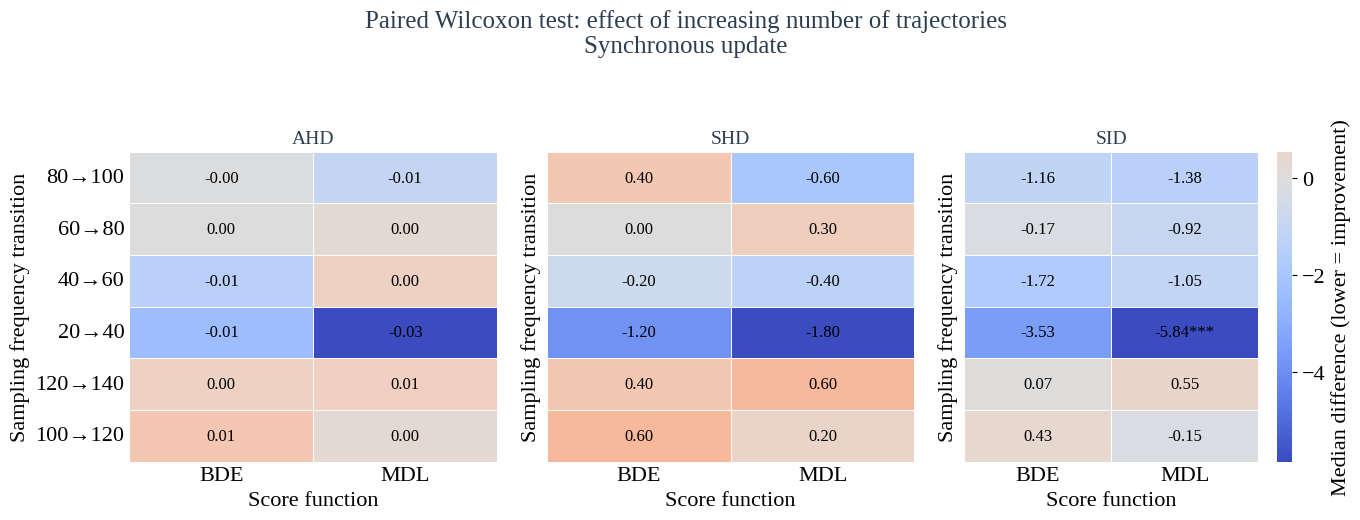

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

df_wilcoxon_a = compute_wilcoxon_table(
    dfa,
    metrics=["AHD", "SHD", "SID"],
    transitions=[(i*20, (i+1)*20) for i in range(1, 7)],
    group_cols=('num_nodes', 'update_mode', 'score_function'),
    sf_col='k_value' 
)
plot_wilcoxon_heatmap(
    df_wilcoxon_a,
    metric="AHD",
    update_mode="asynchronous",
    transitions_order=sorted(df_wilcoxon_a['transition'].unique(), reverse=True),
    ax=axes[0],
    cbar=False
)

plot_wilcoxon_heatmap(
    df_wilcoxon_a,
    metric="SHD",
    update_mode="asynchronous",
    transitions_order=sorted(df_wilcoxon_a['transition'].unique(), reverse=True),
    ax=axes[1],
    cbar=False
)

plot_wilcoxon_heatmap(
    df_wilcoxon_a,
    metric="SID",
    update_mode="asynchronous",
    transitions_order=sorted(df_wilcoxon_a['transition'].unique(), reverse=True),
    ax=axes[2],
    cbar=True
)

fig.suptitle(
    "Paired Wilcoxon test: effect of increasing number of trajectories\n"
    "Synchronous update",
    fontsize=18,
    y=1.05
)

plt.tight_layout()
plt.show()


### Experiment 4

### Experiment 4: Sensitivity to Scoring Function

**Objective:**
The aim of Experiment 4 is to evaluate how the choice of scoring function (MDL vs BDe) affects the quality of Boolean network reconstruction, independently of other factors such as sampling strategy or trajectory length.

**Approach:**
Using datasets generated with fixed sampling and normalization parameters, we assess how the choice of scoring function (MDL vs BDe) influences the accuracy of Boolean network reconstruction across different network sizes and update modes. Reconstruction performance is evaluated in terms of AHD, SHD, and SID, allowing us to capture both topological accuracy and correctness of causal relationships. By systematically comparing these metrics across conditions, we aim to identify scoring function-specific tendencies and understand how the impact of the scoring criterion scales with network size and dynamical properties.

/home/asia/rok3/sad2/final_project/SAD2_final_project/src/sad2_final_project/analysis/analysis.py:933: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(
/home/asia/rok3/sad2/final_project/SAD2_final_project/src/sad2_final_project/analysis/analysis.py:933: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(
/home/asia/rok3/sad2/final_project/SAD2_final_project/src/sad2_final_project/analysis/analysis.py:933: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(


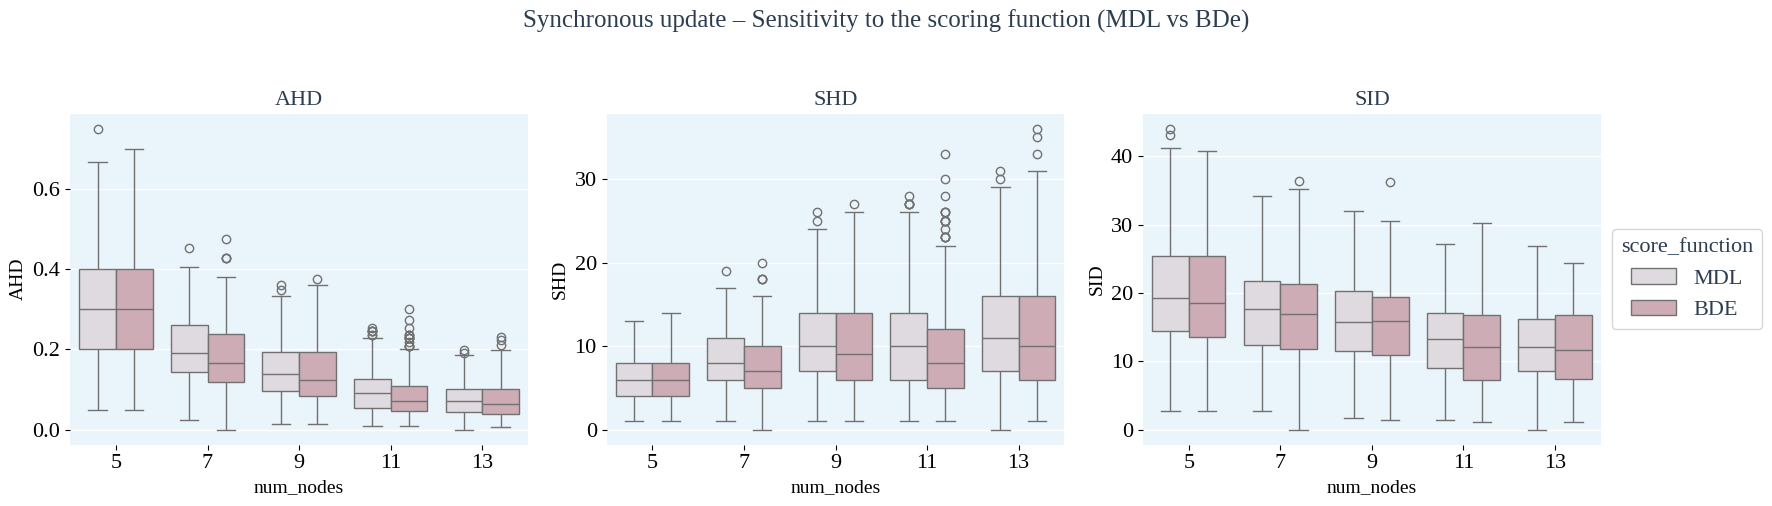

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["AHD", "SHD", "SID"]

# Przygotowujemy jedną figurę z 3 kolumnami
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for i, metric in enumerate(metrics):
    df_long = dfs.melt(
        id_vars=["num_nodes", "score_function"], 
        value_vars=[metric], 
        var_name="metric", 
        value_name="metric_value"
    )

    # Rysujemy boxplot
    plot_boxplot(
        df=df_long,
        x="num_nodes",
        y="metric_value",
        hue="score_function",
        title=metric,
        ax=axes[i],
        show_legend=(i == 2),
        y_label=metric
    )

fig.suptitle(
    "Synchronous update – Sensitivity to the scoring function (MDL vs BDe)", 
    fontsize=18, y=1.02
)
plt.tight_layout()
plt.show()


#### Results

Analysis of reconstruction performance across different network sizes reveals distinct trends for the three evaluated metrics.

* **Adjusted Hamming Distance (AHD):** A clear decreasing trend is observed as the number of nodes increases. For small networks (5 nodes), the median AHD is approximately 0.3, with values ranging from 0.2 to 0.4, whereas for larger networks (13 nodes) the median drops to around 0.1. This indicates that, in relative terms, structural mismatches become proportionally smaller in larger networks.

* **Structural Hamming Distance (SHD):** In contrast, SHD exhibits a slight increasing trend with network size. The median SHD for 5-node networks is around 5, while for 13-node networks it exceeds 10. This reflects the absolute number of edge modifications required to match the true network, which naturally grows as networks become larger and more complex.

* **Structural Intervention Distance (SID):** Similar to AHD, SID tends to decrease with network size. For 5-node networks, the median SID is approximately 20, whereas for 13-node networks it falls below 15. This suggests that larger networks, despite having more nodes, show fewer errors in predicted causal effects relative to the total number of node pairs.

Overall, these results indicate that while absolute reconstruction errors (SHD) increase with network size, relative structural and causal accuracy (AHD, SID) improves, highlighting that scoring function sensitivity remains consistent but its practical impact diminishes in larger networks.


/home/asia/rok3/sad2/final_project/SAD2_final_project/src/sad2_final_project/analysis/analysis.py:933: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(
/home/asia/rok3/sad2/final_project/SAD2_final_project/src/sad2_final_project/analysis/analysis.py:933: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(
/home/asia/rok3/sad2/final_project/SAD2_final_project/src/sad2_final_project/analysis/analysis.py:933: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.boxplot(


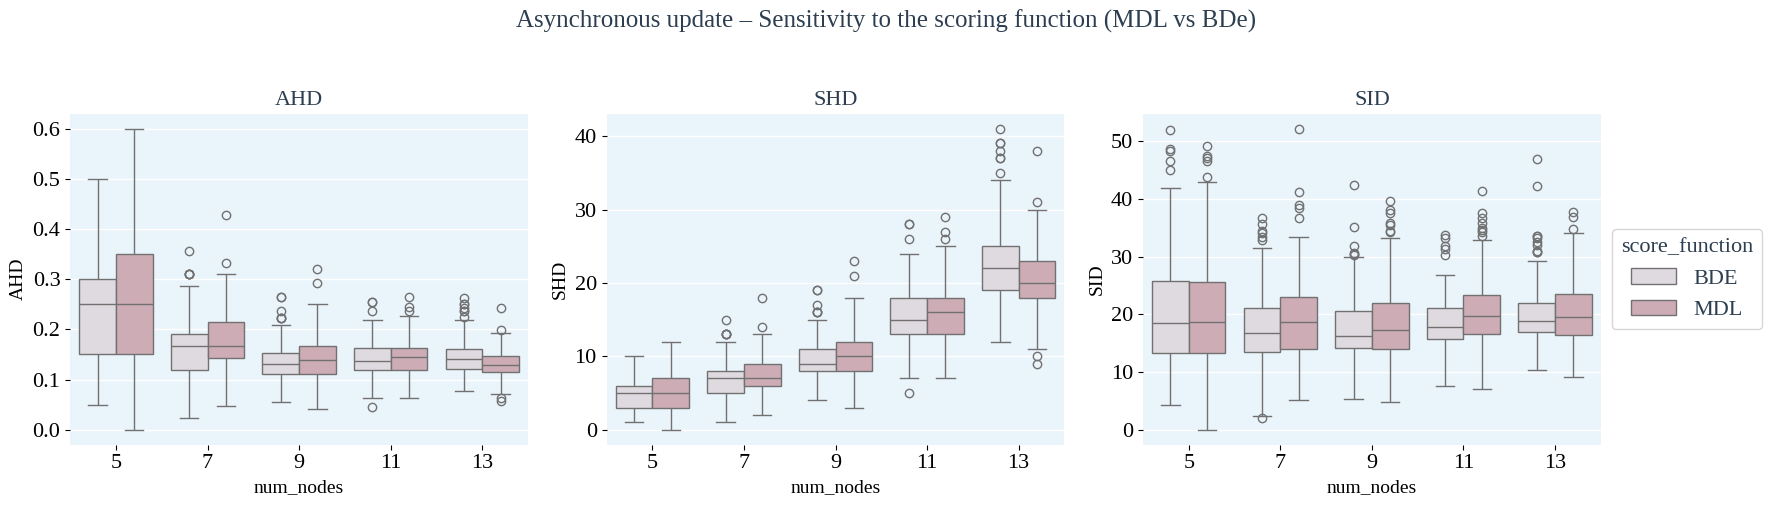

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["AHD", "SHD", "SID"]

# Przygotowujemy jedną figurę z 3 kolumnami
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for i, metric in enumerate(metrics):
    df_longa = dfa.melt(
        id_vars=["num_nodes", "score_function"], 
        value_vars=[metric], 
        var_name="metric", 
        value_name="metric_value"
    )

    # Rysujemy boxplot
    plot_boxplot(
        df=df_longa,
        x="num_nodes",
        y="metric_value",
        hue="score_function",
        title=metric,
        ax=axes[i],
        show_legend=(i == 2),
        y_label=metric
    )

fig.suptitle(
    "Asynchronous update – Sensitivity to the scoring function (MDL vs BDe)", 
    fontsize=18, y=1.02
)
plt.tight_layout()
plt.show()


#### Results

For asynchronous networks, reconstruction performance shows distinct patterns compared to synchronous dynamics:

* **Adjusted Hamming Distance (AHD):** AHD decreases with network size, with a median of 0.25 for 5-node networks and a wide variability across repetitions. At 7 nodes, the median drops below 0.2, accompanied by a notably reduced spread. For larger networks, the median stabilizes slightly above 0.1, with low variability. This indicates that, under asynchronous updates, relative structural mismatches diminish as network size grows, and the reconstruction becomes more consistent across repetitions.

* **Structural Hamming Distance (SHD):** SHD shows an increasing trend with network size. Starting from a median of 5 for 5-node networks, it rises to approximately 21 for the largest networks. This reflects the absolute number of edge edits required to recover the true structure, which naturally grows with network complexity, while the variability remains low.

* **Structural Intervention Distance (SID):** SID remains approximately constant across network sizes, with a median around 18. This suggests that the accuracy of inferred causal relationships is relatively insensitive to network size under asynchronous dynamics.

Scoring Function (MDL vs BDe): Both scoring functions for both synchronous and asynchronous updates produce virtually identical results across all metrics and network sizes, indicating that under asynchronous updates, the choice of scoring function has little effect on reconstruction outcomes.


# Part 2

## Methodology

## Analysis